# King County House Sales - Modeling

## Initial Setup

In [1]:
#Setting up environment with initial libraries needed for importing, cleaning, and initial visualization
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from scipy import stats
from scipy.stats import probplot

import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import sweetviz as sv

import cufflinks as cf
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 25)
pd.set_option('display.float_format', '{:,}'.format)

sns.set_style('darkgrid')

%matplotlib inline

kchouse_model = pd.read_csv('kchouse_model.csv')

C:\Users\jtang\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#define function to iterate through columns for custom descriptive statistics table
def eda_table(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isna().sum()
    eda_df['null_prct'] = df.isna().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    
    return pd.DataFrame(eda_df)

### Sweet Viz and Pandas Profile Report

In [3]:
#create sweet viz visualization for model dataset and export to html
#sweetviz_base = sv.analyze(kchouse_model, target_feat = 'price')
#sweetviz_base.show_html('sweetviz_model.html')

#### Link to Sweet Viz visualizations: [sweetviz_model.html](sweetviz_model.html)

#### Link to Pandas Profile for model dataset: [kchouseprofile_model.html](kchouseprofile_model.html)

In [4]:
kchouse_model.head()

Unnamed: 0          id        date     price  bedrooms  bathrooms  \
0           0  7129300520  2014-10-13 221,900.0         3        1.0   
1           1  6414100192  2014-12-09 538,000.0         3       2.25   
2           2  5631500400  2015-02-25 180,000.0         2        1.0   
3           3  2487200875  2014-12-09 604,000.0         4        3.0   
4           4  1954400510  2015-02-18 510,000.0         3        2.0   

   sqft_living  sqft_lot  floors  waterfront  view  condition  ...       city  \
0         1180      5650     1.0         0.0   0.0          3  ...    Seattle   
1         2570      7242     2.0         0.0   0.0          3  ...    Seattle   
2          770     10000     1.0         0.0   0.0          3  ...    Kenmore   
3         1960      5000     1.0         0.0   0.0          5  ...    Seattle   
4         1680      8080     1.0         0.0   0.0          3  ...  Sammamish   

   livable  q2_2014  q3_2014  q4_2014  q1_2015  q2_2015   log_sqft_living  \
0        1        0        0        1        0        0 7.073269717459709   
1        1        0        0        1        0        0 7.851661177889265   
2        1        0        0        0        1        0 6.646390514847728   
3        1        0        0        1        0        0 7.580699752224562   
4        1        0        0        0        1        0 7.426549072397305   

       log_sqft_lot     log_sqft_above log_sqft_living15    log_sqft_lot15  
0 8.639410824140487  7.073269717459709 7.200424892944957 8.639410824140487  
1 8.887652690325586 7.6824824465345065 7.432483807917119  8.94102198354136  
2 9.210340371976184  6.646390514847728 7.908387159290043 8.994916943677111  
3 8.517193191416238  6.956545443151568 7.215239978730098 8.517193191416238  
4 8.997147151515144  7.426549072397305 7.495541943884256 8.923058219545727  

[5 rows x 34 columns]

In [5]:
kchouse_model.describe()

Unnamed: 0                   id              price  \
count            21,593.0             21,593.0           21,593.0   
mean  10,798.316259899042 4,580,300,249.665308 540,352.6882786088   
std    6,234.958929956687 2,876,833,103.152996 367,377.5333122667   
min                   0.0          1,000,102.0           78,000.0   
25%               5,399.0      2,123,049,142.0          322,000.0   
50%              10,798.0      3,904,930,240.0          450,000.0   
75%              16,198.0      7,308,900,490.0          645,000.0   
max              21,596.0      9,900,000,190.0        7,700,000.0   

                bedrooms          bathrooms         sqft_living  \
count           21,593.0           21,593.0            21,593.0   
mean   3.372018709767054 2.1161255962580467 2,080.4784420877136   
std   0.9039294469150001 0.7687409369657962   918.0763766864567   
min                  1.0               0.75               370.0   
25%                  3.0               1.75             1,430.0   
50%                  3.0               2.25             1,910.0   
75%                  4.0                2.5             2,550.0   
max                 11.0                8.0            13,540.0   

                 sqft_lot             floors           waterfront  \
count            21,593.0           21,593.0             21,593.0   
mean  15,101.193396007966 1.4941416199694346 0.006761450470059742   
std    41,416.25276230656 0.5396903707861491  0.08195147519339266   
min                 520.0                1.0                  0.0   
25%               5,040.0                1.0                  0.0   
50%               7,620.0                1.5                  0.0   
75%              10,687.0                2.0                  0.0   
max           1,651,359.0                3.5                  1.0   

                     view          condition              grade  ...  \
count            21,593.0           21,593.0           21,593.0  ...   
mean  0.23322372991247164  3.409855045616635  7.658176260825267  ...   
std    0.7647368185445763 0.6505755583822345 1.1730580386964635  ...   
min                   0.0                1.0                3.0  ...   
25%                   0.0                3.0                7.0  ...   
50%                   0.0                3.0                7.0  ...   
75%                   0.0                4.0                8.0  ...   
max                   4.0                5.0               13.0  ...   

               sqft_lot15             livable             q2_2014  \
count            21,593.0            21,593.0            21,593.0   
mean  12,759.564210623814  0.9796693372852313 0.18274440790997082   
std    27,276.78982375412 0.14113202793291676  0.3864657891066632   
min                 651.0                 0.0                 0.0   
25%               5,100.0                 1.0                 0.0   
50%               7,620.0                 1.0                 0.0   
75%              10,083.0                 1.0                 0.0   
max             871,200.0                 1.0                 1.0   

                 q3_2014            q4_2014             q1_2015  \
count           21,593.0           21,593.0            21,593.0   
mean  0.2741629231695457 0.2201176307136572  0.1898300375121567   
std   0.4461018168475007 0.4143353832353193 0.39217562026273156   
min                  0.0                0.0                 0.0   
25%                  0.0                0.0                 0.0   
50%                  0.0                0.0                 0.0   
75%                  1.0                0.0                 0.0   
max                  1.0                1.0                 1.0   

                  q2_2015     log_sqft_living       log_sqft_lot  \
count            21,593.0            21,593.0           21,593.0   
mean  0.13314500069466956   7.550824448748599  8.989903616131151   
std   0.33973924539717665 0.42410642672015575 0.9020928296078294   
min                 

### Dropping columns that have log transform equivalents

In [6]:
kchouse_model1 = kchouse_model.drop(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1)
kchouse_model1.head()

Unnamed: 0          id        date     price  bedrooms  bathrooms  floors  \
0           0  7129300520  2014-10-13 221,900.0         3        1.0     1.0   
1           1  6414100192  2014-12-09 538,000.0         3       2.25     2.0   
2           2  5631500400  2015-02-25 180,000.0         2        1.0     1.0   
3           3  2487200875  2014-12-09 604,000.0         4        3.0     1.0   
4           4  1954400510  2015-02-18 510,000.0         3        2.0     1.0   

   waterfront  view  condition  grade  sqft_basement  ...       city  livable  \
0         0.0   0.0          3      7            0.0  ...    Seattle        1   
1         0.0   0.0          3      7          400.0  ...    Seattle        1   
2         0.0   0.0          3      6            0.0  ...    Kenmore        1   
3         0.0   0.0          5      7          910.0  ...    Seattle        1   
4         0.0   0.0          3      8            0.0  ...  Sammamish        1   

   q2_2014  q3_2014  q4_2014 q1_2015  q2_2015   log_sqft_living  \
0        0        0        1       0        0 7.073269717459709   
1        0        0        1       0        0 7.851661177889265   
2        0        0        0       1        0 6.646390514847728   
3        0        0        1       0        0 7.580699752224562   
4        0        0        0       1        0 7.426549072397305   

       log_sqft_lot     log_sqft_above  log_sqft_living15    log_sqft_lot15  
0 8.639410824140487  7.073269717459709  7.200424892944957 8.639410824140487  
1 8.887652690325586 7.6824824465345065  7.432483807917119  8.94102198354136  
2 9.210340371976184  6.646390514847728  7.908387159290043 8.994916943677111  
3 8.517193191416238  6.956545443151568  7.215239978730098 8.517193191416238  
4 8.997147151515144  7.426549072397305  7.495541943884256 8.923058219545727  

[5 rows x 29 columns]

In [7]:
eda_table(kchouse_model1)

null_sum  null_prct   dtypes  count                 mean  \
Unnamed: 0                0        0.0    int64  21593  10,798.316259899042   
bathrooms                 0        0.0  float64  21593   2.1161255962580467   
bedrooms                  0        0.0    int64  21593    3.372018709767054   
city                      0        0.0   object  21593                  nan   
condition                 0        0.0    int64  21593    3.409855045616635   
date                      0        0.0   object  21593                  nan   
floors                    0        0.0  float64  21593   1.4941416199694346   
grade                     0        0.0    int64  21593    7.658176260825267   
id                        0        0.0    int64  21593 4,580,300,249.665308   
lat                       0        0.0  float64  21593   47.560095595794934   
livable                   0        0.0    int64  21593   0.9796693372852313   
log_sqft_above            0        0.0  float64  21593    7.395281436695742   
log_sqft_living           0        0.0  float64  21593    7.550824448748599   
log_sqft_living15         0        0.0  float64  21593    7.539531474350569   
log_sqft_lot              0        0.0  float64  21593    8.989903616131151   
log_sqft_lot15            0        0.0  float64  21593    8.960825422816484   
long                      0        0.0  float64  21593  -122.21397036076507   
price                     0        0.0  float64  21593   540,352.6882786088   
q1_2015                   0        0.0    int64  21593   0.1898300375121567   
q2_2014                   0        0.0    int64  21593  0.18274440790997082   
q2_2015                   0        0.0    int64  21593  0.13314500069466956   
q3_2014                   0        0.0    int64  21593   0.2741629231695457   
q4_2014                   0        0.0    int64  21593   0.2201176307136572   
sqft_basement             0        0.0  float64  21593    285.7245866716065   
view                      0        0.0  float64  21593  0.23322372991247164   
waterfront                0        0.0  float64  21593 0.006761450470059742   
yr_built                  0        0.0    int64  21593  1,971.0039364608901   
yr_renovated              0        0.0  float64  21593    68.77094428750058   
zipcode                   0        0.0    int64  21593    98,077.9435465197   

                             median               min                max  
Unnamed: 0                 10,798.0                 0              21596  
bathrooms                      2.25              0.75                8.0  
bedrooms                        3.0                 1                 11  
city                            nan            Auburn        Woodinville  
condition                       3.0                 1                  5  
date                            nan        2014-05-02         2015-05-27  
floors                          1.5               1.0                3.5  
grade                           7.0                 3                 13  
id                  3,904,930,240.0           1000102         9900000190  
lat                         47.5718           47.1559            47.7776  
livable                         1.0                 0                  1  
log_sqft_above    7.352441100243581 5.913503005638269  9.149528232579426  
log_sqft_living   7.554858521040676 5.913503005638269  9.513403546466266  
log_sqft_living15 7.517520850603031 5.988961416889863  8.733916174927524  
log_sqft_lot      8.938531648680692 6.253828811575472 14.317109143238099  
log_sqft_lot15    8.938531648680692 6.478509642208568 13.677626850600886  
long                       -122.231          -122.519           -121.315  
price                     450,000.0          78,000.0        7,700,000.0  
q1_2015                         0.0                 0                  1  
q2_2014                         0.0                 0                  1  
q2_2015                         0.0                 0                  1 

## OLS - Model 1

In [8]:
data = kchouse_model1
target = 'price'
x_cols = kchouse_model1.drop([target, 'date','id'], axis=1).columns
predictors = '+'.join(x_cols)
f = target + '~' + predictors

model = smf.ols(formula=f, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     1310.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        20:41:50   Log-Likelihood:            -2.9293e+05
No. Observations:               21593   AIC:                         5.860e+05
Df Residuals:                   21546   BIC:                         5.863e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              6.653e+07    6.9e+06      9.642      0.000     5.3e+07    8.01e+07
city[T.Bellevue]       2.036e+05   1.03e+04     19.698      0.000    1.83e+05    2.24e+05
city[T.Black Diamond]  1.141e+05   2.12e+04      5.378      0.000    7.25e+04    1.56e+05
city[T.Bothell]       -1.041e+05   1.75e+04     -5.957      0.000   -1.38e+05   -6.98e+04
city[T.Carnation]      5.431e+04   2.31e+04      2.352      0.019    9047.867    9.96e+04
city[T.Duvall]        -2.837e+04   1.96e+04     -1.451      0.147   -6.67e+04    9956.558
city[T.Enumclaw]       8.833e+04   1.58e+04      5.597      0.000    5.74e+04    1.19e+05
city[T.Fall City]      1.535e+05   2.49e+04      6.169      0.000    1.05e+05    2.02e+05
city[T.Federal Way]    -9.31e+04   1.01e+04     -9.232      0.000   -1.13e+05   -7.33e+04
city[T.Issaquah]       1.051e+05   1.23e+04      8.523      0.000    8.09e+04    1.29e+05
city[T.Kenmore]       -9.562e+04   1.58e+04     -6.041      0.000   -1.27e+05   -6.46e+04
city[T.Kent]          -1826.9839   8619.129     -0.212      0.832   -1.87e+04    1.51e+04
city[T.Kirkland]       1.003e+05    1.2e+04      8.332      0.000    7.67e+04    1.24e+05
city[T.Maple Valley]   7.293e+04   1.17e+04      6.222      0.000       5e+04    9.59e+04
city[T.Medina]         1.181e+06   2.84e+04     41.586      0.000    1.13e+06    1.24e+06
city[T.Mercer Island]  3.527e+05   1.42e+04     24.896      0.000    3.25e+05     3.8e+05
city[T.North Bend]     1.802e+05   2.07e+04      8.726      0.000     1.4e+05    2.21e+05
city[T.Redmond]        1.207e+05   1.28e+04      9.404      0.000    9.56e+04    1.46e+05
city[T.Renton]         4.262e+04   9124.001      4.671      0.000    2.47e+04    6.05e+04
city[T.Sammamish]      1.376e+05   1.33e+04     10.351      0.000    1.12e+05    1.64e+05
city[T.Seattle]        1.984e+05   1.34e+04     14.772      0.000    1.72e+05    2.25e+05
city[T.Snoqualmie]      1.55e+05   1.79e+04      8.683      0.000     1.2e+05     1.9e+05
city[T.Vashon]        -6.662e+04    2.1e+04     -3.172      0.002   -1.08e+05   -2.54e+04
city[T.Woodinville]    2.796e+04   1.54e+04      1.821      0.069   -2133.883    5.81e+04
bedrooms               -2.06e+04   1947.281    -10.581      0.000   -2.44e+04   -1.68e+04
bathrooms              6.852e+04   3062.246     22.374      0.000    6.25e+04    7.45e+04
floors                -4486.3182   3844.892     -1.167      0.243    -1.2e+04    3049.956
waterfront             6.572e+05   1.72e+04     38.258      0.000    6.24e+05    6.91e+05
view                   4.522e+04   2019.421     22.395      0.000    4.13e+04    4.92e+04
condition              2.975e+04   2288.608     12.998      0.000    2.53e+04    3.42e+04
grade                  1.162e+05   2051.885     56.638      0.000    1.12e+05     1.2e+05
sqft_basement          

R-squared value down to .737!

### Multicollinearity

<AxesSubplot:>

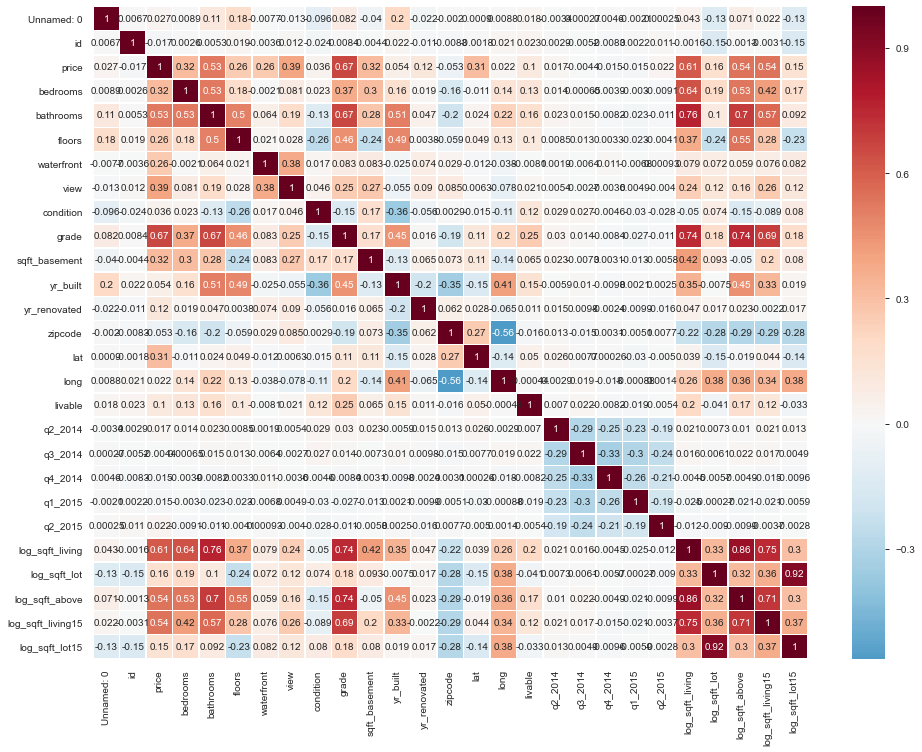

In [9]:
#create correlation heatmap to visualize collinearity
plt.figure(figsize=(16,12))
pcorr = kchouse_model1.corr()
cmap = 'RdBu_r'
sns.heatmap(pcorr, 
            xticklabels=pcorr.columns, 
            yticklabels=pcorr.columns,
            cmap=cmap,
            annot=True,
            linewidth=0.5,
            center=0)

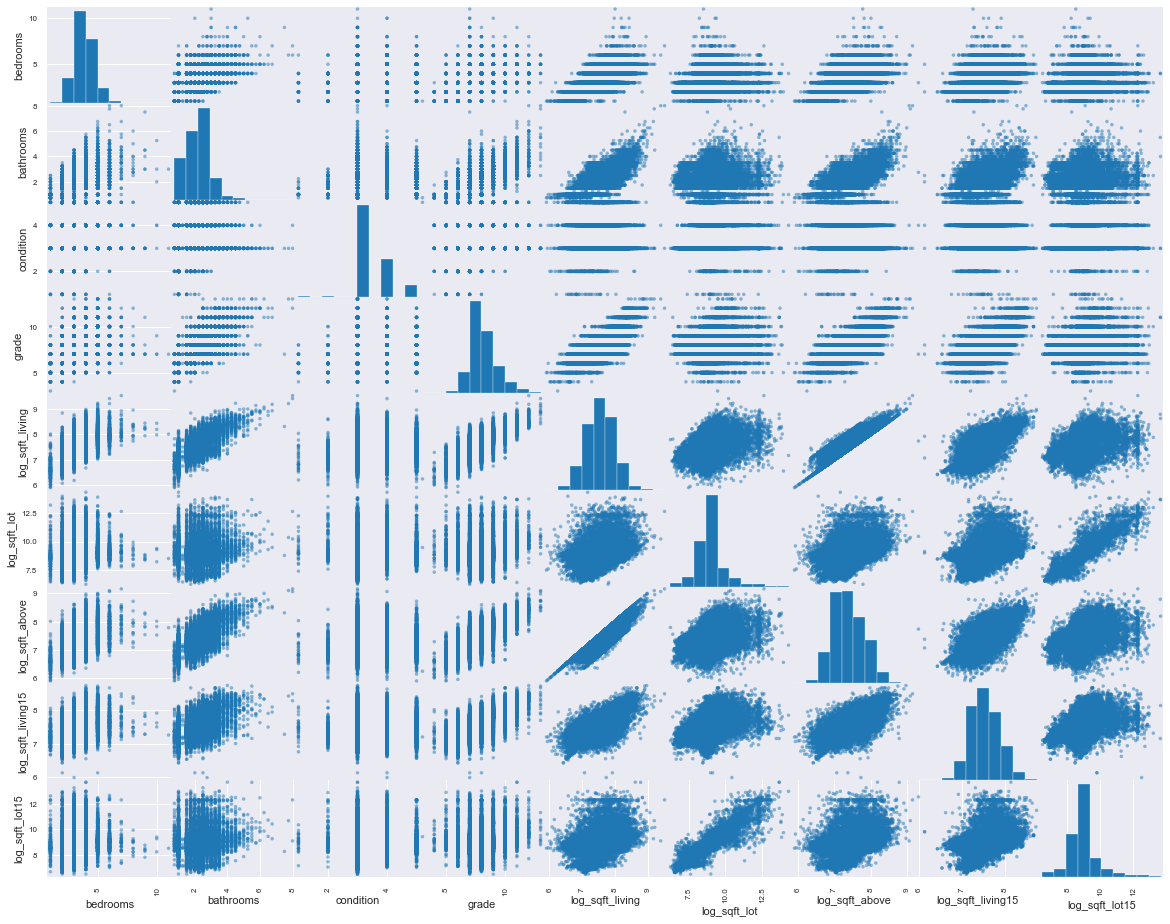

In [10]:
#create a scatterplot matrix of select predictor variables to see relationships between variables
pred = ['bedrooms', 'bathrooms', 'condition', 'grade', 'log_sqft_living', 'log_sqft_lot', 'log_sqft_above', 'log_sqft_living15', 'log_sqft_lot15']
kchouse_pred = kchouse_model1[pred]
pd.plotting.scatter_matrix(kchouse_pred,figsize  = [20, 16]);
plt.show()

In [11]:
#call correlation stats for predictor variables
kchouse_pred.corr()

bedrooms            bathrooms  \
bedrooms                           1.0   0.5277530348839268   
bathrooms           0.5277530348839268                  1.0   
condition         0.023361266929830916 -0.12663229943418733   
grade              0.36592047931946037   0.6657850106118681   
log_sqft_living      0.637524002521876   0.7621540412275915   
log_sqft_lot       0.18981010598841647  0.10044212415251492   
log_sqft_above      0.5300488624768226    0.695785934777404   
log_sqft_living15  0.41816888789456663   0.5718154181124852   
log_sqft_lot15     0.16707036279567883  0.09184266482440007   

                             condition                grade  \
bedrooms          0.023361266929830916  0.36592047931946037   
bathrooms         -0.12663229943418733   0.6657850106118681   
condition                          1.0 -0.14697345489897545   
grade             -0.14697345489897545                  1.0   
log_sqft_living   -0.04971097413718952   0.7429208411139804   
log_sqft_lot       0.07363688274183691  0.18424664549292993   
log_sqft_above    -0.15083333920798203   0.7427671891844515   
log_sqft_living15 -0.08926789277975655   0.6890568760852902   
log_sqft_lot15     0.07980462199341093  0.18492833363893346   

                       log_sqft_living        log_sqft_lot  \
bedrooms             0.637524002521876 0.18981010598841647   
bathrooms           0.7621540412275915 0.10044212415251492   
condition         -0.04971097413718952 0.07363688274183691   
grade               0.7429208411139804 0.18424664549292993   
log_sqft_living                    1.0   0.325939532295306   
log_sqft_lot         0.325939532295306                 1.0   
log_sqft_above      0.8649413856627083 0.31860079000905245   
log_sqft_living15   0.7468951530613002   0.363707731041516   
log_sqft_lot15      0.3030043170519009   0.918667735842804   

                        log_sqft_above    log_sqft_living15  \
bedrooms            0.5300488624768226  0.41816888789456663   
bathrooms            0.695785934777404   0.5718154181124852   
condition         -0.15083333920798203 -0.08926789277975655   
grade               0.7427671891844515   0.6890568760852902   
log_sqft_living     0.8649413856627083   0.7468951530613002   
log_sqft_lot       0.31860079000905245    0.363707731041516   
log_sqft_above                     1.0    0.713187140196981   
log_sqft_living15    0.713187140196981                  1.0   
log_sqft_lot15     0.29866312222131697   0.3735951380919623   

                       log_sqft_lot15  
bedrooms          0.16707036279567883  
bathrooms         0.09184266482440007  
condition         0.07980462199341093  
grade             0.18492833363893346  
log_sqft_living    0.3030043170519009  
log_sqft_lot        0.918667735842804  
log_sqft_above    0.29866312222131697  
log_sqft_living15  0.3735951380919623  
log_sqft_lot15                    1.0

In [12]:
#generate matrix of predictor collinearity greater than .7
abs(kchouse_pred.corr()) > 0.7

bedrooms  bathrooms  condition  grade  log_sqft_living  \
bedrooms               True      False      False  False            False   
bathrooms             False       True      False  False             True   
condition             False      False       True  False            False   
grade                 False      False      False   True             True   
log_sqft_living       False       True      False   True             True   
log_sqft_lot          False      False      False  False            False   
log_sqft_above        False      False      False   True             True   
log_sqft_living15     False      False      False  False             True   
log_sqft_lot15        False      False      False  False            False   

                   log_sqft_lot  log_sqft_above  log_sqft_living15  \
bedrooms                  False           False              False   
bathrooms                 False           False              False   
condition                 False           False              False   
grade                     False            True              False   
log_sqft_living           False            True               True   
log_sqft_lot               True           False              False   
log_sqft_above            False            True               True   
log_sqft_living15         False            True               True   
log_sqft_lot15             True           False              False   

                   log_sqft_lot15  
bedrooms                    False  
bathrooms                   False  
condition                   False  
grade                       False  
log_sqft_living             False  
log_sqft_lot                 True  
log_sqft_above              False  
log_sqft_living15           False  
log_sqft_lot15               True

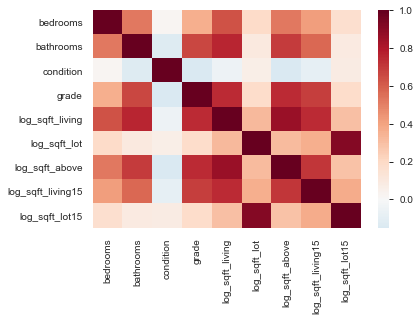

In [13]:
#create heatmap of predictor variables
import seaborn as sns
sns.heatmap(kchouse_pred.corr(), cmap=cmap, center=0);

In [14]:
#dropping log_sqft_above from model dataframe as it is indicated in log_sqft_living
kchouse_model1a = kchouse_model1.drop(['log_sqft_above'], axis=1)
kchouse_model1a.head()

Unnamed: 0          id        date     price  bedrooms  bathrooms  floors  \
0           0  7129300520  2014-10-13 221,900.0         3        1.0     1.0   
1           1  6414100192  2014-12-09 538,000.0         3       2.25     2.0   
2           2  5631500400  2015-02-25 180,000.0         2        1.0     1.0   
3           3  2487200875  2014-12-09 604,000.0         4        3.0     1.0   
4           4  1954400510  2015-02-18 510,000.0         3        2.0     1.0   

   waterfront  view  condition  grade  sqft_basement  ...     long       city  \
0         0.0   0.0          3      7            0.0  ... -122.257    Seattle   
1         0.0   0.0          3      7          400.0  ... -122.319    Seattle   
2         0.0   0.0          3      6            0.0  ... -122.233    Kenmore   
3         0.0   0.0          5      7          910.0  ... -122.393    Seattle   
4         0.0   0.0          3      8            0.0  ... -122.045  Sammamish   

   livable  q2_2014  q3_2014 q4_2014  q1_2015  q2_2015   log_sqft_living  \
0        1        0        0       1        0        0 7.073269717459709   
1        1        0        0       1        0        0 7.851661177889265   
2        1        0        0       0        1        0 6.646390514847728   
3        1        0        0       1        0        0 7.580699752224562   
4        1        0        0       0        1        0 7.426549072397305   

       log_sqft_lot  log_sqft_living15    log_sqft_lot15  
0 8.639410824140487  7.200424892944957 8.639410824140487  
1 8.887652690325586  7.432483807917119  8.94102198354136  
2 9.210340371976184  7.908387159290043 8.994916943677111  
3 8.517193191416238  7.215239978730098 8.517193191416238  
4 8.997147151515144  7.495541943884256 8.923058219545727  

[5 rows x 28 columns]

### OLS - Model 1b

In [15]:
data = kchouse_model1a
target = 'price'
x_cols = kchouse_model1a.drop([target, 'date','id'], axis=1).columns
predictors = '+'.join(x_cols)
f = target + '~' + predictors

model = smf.ols(formula=f, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1246.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        20:42:04   Log-Likelihood:            -2.9350e+05
No. Observations:               21593   AIC:                         5.871e+05
Df Residuals:                   21547   BIC:                         5.875e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              6.125e+07   7.08e+06      8.648      0.000    4.74e+07    7.51e+07
city[T.Bellevue]       2.051e+05   1.06e+04     19.327      0.000    1.84e+05    2.26e+05
city[T.Black Diamond]  1.021e+05   2.18e+04      4.687      0.000    5.94e+04    1.45e+05
city[T.Bothell]       -1.089e+05   1.79e+04     -6.067      0.000   -1.44e+05   -7.37e+04
city[T.Carnation]      3.707e+04   2.37e+04      1.564      0.118   -9391.431    8.35e+04
city[T.Duvall]        -3.749e+04   2.01e+04     -1.867      0.062   -7.68e+04    1864.911
city[T.Enumclaw]       8.557e+04   1.62e+04      5.281      0.000    5.38e+04    1.17e+05
city[T.Fall City]      1.343e+05   2.55e+04      5.259      0.000    8.42e+04    1.84e+05
city[T.Federal Way]   -9.438e+04   1.04e+04     -9.115      0.000   -1.15e+05   -7.41e+04
city[T.Issaquah]       9.545e+04   1.27e+04      7.542      0.000    7.06e+04     1.2e+05
city[T.Kenmore]        -1.05e+05   1.62e+04     -6.465      0.000   -1.37e+05   -7.32e+04
city[T.Kent]          -5166.4491   8848.959     -0.584      0.559   -2.25e+04    1.22e+04
city[T.Kirkland]       9.355e+04   1.24e+04      7.572      0.000    6.93e+04    1.18e+05
city[T.Maple Valley]   6.629e+04    1.2e+04      5.509      0.000    4.27e+04    8.99e+04
city[T.Medina]         1.195e+06   2.92e+04     40.985      0.000    1.14e+06    1.25e+06
city[T.Mercer Island]  3.628e+05   1.45e+04     24.949      0.000    3.34e+05    3.91e+05
city[T.North Bend]     1.617e+05   2.12e+04      7.628      0.000     1.2e+05    2.03e+05
city[T.Redmond]         1.08e+05   1.32e+04      8.198      0.000    8.22e+04    1.34e+05
city[T.Renton]         3.515e+04   9365.212      3.753      0.000    1.68e+04    5.35e+04
city[T.Sammamish]      1.152e+05   1.36e+04      8.450      0.000    8.85e+04    1.42e+05
city[T.Seattle]        1.725e+05   1.38e+04     12.535      0.000    1.46e+05       2e+05
city[T.Snoqualmie]     1.466e+05   1.83e+04      7.996      0.000    1.11e+05    1.82e+05
city[T.Vashon]         -8.16e+04   2.16e+04     -3.784      0.000   -1.24e+05   -3.93e+04
city[T.Woodinville]    7728.9309   1.58e+04      0.491      0.624   -2.31e+04    3.86e+04
bedrooms              -1.842e+04   1998.260     -9.219      0.000   -2.23e+04   -1.45e+04
bathrooms              7.323e+04   3140.916     23.314      0.000    6.71e+04    7.94e+04
floors                 2.396e+04   3854.068      6.218      0.000    1.64e+04    3.15e+04
waterfront             6.666e+05   1.76e+04     37.801      0.000    6.32e+05    7.01e+05
view                   5.142e+04   2065.023     24.902      0.000    4.74e+04    5.55e+04
condition              2.664e+04   2347.933     11.347      0.000     2.2e+04    3.12e+04
grade                  1.274e+05   2079.668     61.270      0.000    1.23e+05    1.31e+05
sqft_basement          

R-squared value at .722!

### Model Validation - Train_Test_Split

In [16]:
data = kchouse_model1a
y = data['price']
X = data.drop(['price','date','id','zipcode', 'city'], axis = 1)

In [17]:
# create data sets with an 80/20 split - train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [18]:
len(y_test)

4319

In [19]:
#MSE of train and validation data sets
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 43567112950.09455
Test Mean Squarred Error: 52807456013.62048


In [20]:
#RMSE of train and validation data sets
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
print('Train Root Mean Squarred Error:', rmse_train)
print('Test Root Mean Squarred Error:', rmse_test)

Train Root Mean Squarred Error: 208727.3651203755
Test Root Mean Squarred Error: 229798.72935597465


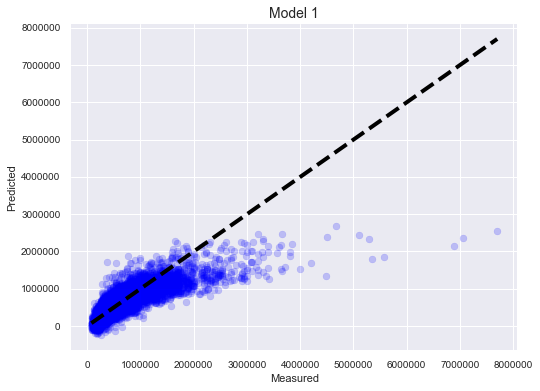

In [185]:
#plot cross-validation predictions
predicted = cross_val_predict(linreg, X, y, cv=10)

fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(y, predicted, alpha=0.2, color='blue')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Model 1', size=14)
ax.ticklabel_format(style='plain')
plt.show()

<AxesSubplot:xlabel='price'>

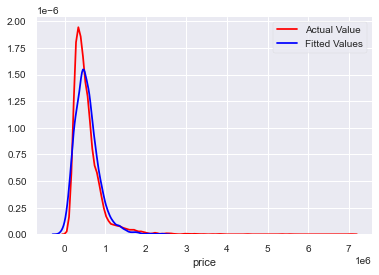

In [22]:
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_hat_test, hist=False, color="b", label="Fitted Values" , ax=ax1)

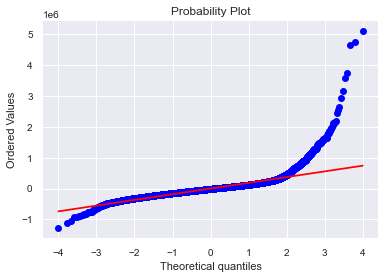

In [23]:
#check distribution of residuals using probability plot 
base_X = X
base_y_predicted = linreg.predict(base_X)
base_residuals = y - base_y_predicted

_ = probplot(base_residuals, plot=plt)

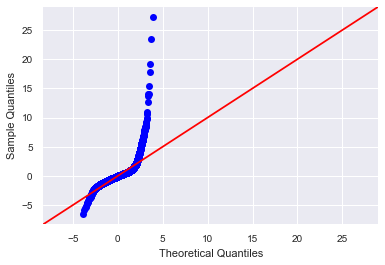

In [24]:
#check normality of residuals using Q-Q plot
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

#### Observations: ~5% difference between train and test data RMSE, fit of predicted values falls off for upper sale prices with residuals showing a non-linear fit, suggesting model is not a good predictor of house sale prices overall even with an acceptable R-squared value and needs further refinement.

## OLS - Model 2 - Simplifying

Reducing the complexity of dataset an narrowing in on variables that have higher correlation with price.

In [69]:
#call dataframe with custom function
eda_table(kchouse_model)

null_sum  null_prct   dtypes  count                 mean  \
Unnamed: 0           0        0.0    int64  21593  10,798.316259899042   
bathrooms            0        0.0  float64  21593   2.1161255962580467   
bedrooms             0        0.0    int64  21593    3.372018709767054   
city                 0        0.0   object  21593                  nan   
condition            0        0.0    int64  21593    3.409855045616635   
...                ...        ...      ...    ...                  ...   
view                 0        0.0  float64  21593  0.23322372991247164   
waterfront           0        0.0  float64  21593 0.006761450470059742   
yr_built             0        0.0    int64  21593  1,971.0039364608901   
yr_renovated         0        0.0  float64  21593    68.77094428750058   
zipcode              0        0.0    int64  21593    98,077.9435465197   

               median     min          max  
Unnamed: 0   10,798.0       0        21596  
bathrooms        2.25    0.75          8.0  
bedrooms          3.0       1           11  
city              nan  Auburn  Woodinville  
condition         3.0       1            5  
...               ...     ...          ...  
view              0.0     0.0          4.0  
waterfront        0.0     0.0          1.0  
yr_built      1,975.0    1900         2015  
yr_renovated      0.0     0.0      2,015.0  
zipcode      98,065.0   98001        98199  

[34 rows x 8 columns]

In [97]:
#dropping predictor variables and features to simplify model
kchouse_model2 = kchouse_model.drop(['date', 'view', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_basement', 'q1_2015', 'q2_2014', 'q2_2015', 'q3_2014','q4_2014'], axis=1)
kchouse_model2.head()

Unnamed: 0          id     price  bedrooms  bathrooms  sqft_living  \
0           0  7129300520 221,900.0         3        1.0         1180   
1           1  6414100192 538,000.0         3       2.25         2570   
2           2  5631500400 180,000.0         2        1.0          770   
3           3  2487200875 604,000.0         4        3.0         1960   
4           4  1954400510 510,000.0         3        2.0         1680   

   sqft_lot  floors  waterfront  condition  grade  sqft_above  yr_built  \
0      5650     1.0         0.0          3      7        1180      1955   
1      7242     2.0         0.0          3      7        2170      1951   
2     10000     1.0         0.0          3      6         770      1933   
3      5000     1.0         0.0          5      7        1050      1965   
4      8080     1.0         0.0          3      8        1680      1987   

   sqft_living15  sqft_lot15       city  livable   log_sqft_living  \
0           1340        5650    Seattle        1 7.073269717459709   
1           1690        7639    Seattle        1 7.851661177889265   
2           2720        8062    Kenmore        1 6.646390514847728   
3           1360        5000    Seattle        1 7.580699752224562   
4           1800        7503  Sammamish        1 7.426549072397305   

       log_sqft_lot     log_sqft_above  log_sqft_living15    log_sqft_lot15  
0 8.639410824140487  7.073269717459709  7.200424892944957 8.639410824140487  
1 8.887652690325586 7.6824824465345065  7.432483807917119  8.94102198354136  
2 9.210340371976184  6.646390514847728  7.908387159290043 8.994916943677111  
3 8.517193191416238  6.956545443151568  7.215239978730098 8.517193191416238  
4 8.997147151515144  7.426549072397305  7.495541943884256 8.923058219545727

In [71]:
eda_table(kchouse_model2)

null_sum  null_prct   dtypes  count                 mean  \
Unnamed: 0                0        0.0    int64  21593  10,798.316259899042   
bathrooms                 0        0.0  float64  21593   2.1161255962580467   
bedrooms                  0        0.0    int64  21593    3.372018709767054   
city                      0        0.0   object  21593                  nan   
condition                 0        0.0    int64  21593    3.409855045616635   
floors                    0        0.0  float64  21593   1.4941416199694346   
grade                     0        0.0    int64  21593    7.658176260825267   
id                        0        0.0    int64  21593 4,580,300,249.665308   
livable                   0        0.0    int64  21593   0.9796693372852313   
log_sqft_above            0        0.0  float64  21593    7.395281436695742   
log_sqft_living           0        0.0  float64  21593    7.550824448748599   
log_sqft_living15         0        0.0  float64  21593    7.539531474350569   
log_sqft_lot              0        0.0  float64  21593    8.989903616131151   
log_sqft_lot15            0        0.0  float64  21593    8.960825422816484   
price                     0        0.0  float64  21593   540,352.6882786088   
sqft_above                0        0.0    int64  21593  1,788.7443152873616   
sqft_living               0        0.0    int64  21593  2,080.4784420877136   
sqft_living15             0        0.0    int64  21593  1,986.7021256888806   
sqft_lot                  0        0.0    int64  21593  15,101.193396007966   
sqft_lot15                0        0.0    int64  21593  12,759.564210623814   
waterfront                0        0.0  float64  21593 0.006761450470059742   
yr_built                  0        0.0    int64  21593  1,971.0039364608901   

                             median               min                max  
Unnamed: 0                 10,798.0                 0              21596  
bathrooms                      2.25              0.75                8.0  
bedrooms                        3.0                 1                 11  
city                            nan            Auburn        Woodinville  
condition                       3.0                 1                  5  
floors                          1.5               1.0                3.5  
grade                           7.0                 3                 13  
id                  3,904,930,240.0           1000102         9900000190  
livable                         1.0                 0                  1  
log_sqft_above    7.352441100243581 5.913503005638269  9.149528232579426  
log_sqft_living   7.554858521040676 5.913503005638269  9.513403546466266  
log_sqft_living15 7.517520850603031 5.988961416889863  8.733916174927524  
log_sqft_lot      8.938531648680692 6.253828811575472 14.317109143238099  
log_sqft_lot15    8.938531648680692 6.478509642208568 13.677626850600886  
price                     450,000.0          78,000.0        7,700,000.0  
sqft_above                  1,560.0               370               9410  
sqft_living                 1,910.0               370              13540  
sqft_living15               1,840.0               399               6210  
sqft_lot                    7,620.0               520            1651359  
sqft_lot15                  7,620.0               651             871200  
waterfront                      0.0               0.0                1.0  
yr_built                    1,975.0              1900               2015

In [98]:
data = kchouse_model2
target = 'price'
x_cols = kchouse_model2.drop([target,'id'], axis=1).columns
predictors = '+'.join(x_cols)
f = target + '~' + predictors

model2 = smf.ols(formula=f, data=data).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1600.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:12:22   Log-Likelihood:            -2.9225e+05
No. Observations:               21593   AIC:                         5.846e+05
Df Residuals:                   21551   BIC:                         5.849e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              6.462e+06   1.82e+05     35.580      0.000    6.11e+06    6.82e+06
city[T.Bellevue]       3.285e+05   8045.757     40.834      0.000    3.13e+05    3.44e+05
city[T.Black Diamond]  9.569e+04   1.94e+04      4.942      0.000    5.77e+04    1.34e+05
city[T.Bothell]        1.074e+05   1.45e+04      7.415      0.000     7.9e+04    1.36e+05
city[T.Carnation]      1.275e+05   1.78e+04      7.156      0.000    9.26e+04    1.62e+05
city[T.Duvall]         1.051e+05   1.47e+04      7.166      0.000    7.64e+04    1.34e+05
city[T.Enumclaw]       3.201e+04   1.36e+04      2.356      0.018    5381.658    5.86e+04
city[T.Fall City]        1.7e+05   2.16e+04      7.868      0.000    1.28e+05    2.12e+05
city[T.Federal Way]    -3.09e+04   8972.001     -3.445      0.001   -4.85e+04   -1.33e+04
city[T.Issaquah]       1.387e+05   9191.634     15.091      0.000    1.21e+05    1.57e+05
city[T.Kenmore]         1.11e+05   1.25e+04      8.885      0.000    8.65e+04    1.36e+05
city[T.Kent]           7780.8893   8051.794      0.966      0.334   -8001.223    2.36e+04
city[T.Kirkland]       2.534e+05   8499.794     29.815      0.000    2.37e+05     2.7e+05
city[T.Maple Valley]   3.995e+04   9734.904      4.104      0.000    2.09e+04     5.9e+04
city[T.Medina]         1.186e+06   2.69e+04     44.115      0.000    1.13e+06    1.24e+06
city[T.Mercer Island]  4.344e+05   1.28e+04     33.904      0.000    4.09e+05     4.6e+05
city[T.North Bend]     1.224e+05   1.38e+04      8.847      0.000    9.52e+04    1.49e+05
city[T.Redmond]        1.941e+05   8527.250     22.765      0.000    1.77e+05    2.11e+05
city[T.Renton]         5.309e+04   7627.956      6.961      0.000    3.81e+04     6.8e+04
city[T.Sammamish]      1.306e+05   9129.912     14.308      0.000    1.13e+05    1.49e+05
city[T.Seattle]        1.812e+05   6862.618     26.403      0.000    1.68e+05    1.95e+05
city[T.Snoqualmie]     7.768e+04   1.22e+04      6.347      0.000    5.37e+04    1.02e+05
city[T.Vashon]         6.548e+04   1.85e+04      3.535      0.000    2.92e+04    1.02e+05
city[T.Woodinville]    1.227e+05   1.06e+04     11.583      0.000    1.02e+05    1.43e+05
bedrooms              -1.971e+04   1887.128    -10.443      0.000   -2.34e+04    -1.6e+04
bathrooms              4.836e+04   2986.723     16.193      0.000    4.25e+04    5.42e+04
sqft_living             367.7880      8.454     43.504      0.000     351.217     384.359
sqft_lot                  0.2092      0.053      3.983      0.000       0.106       0.312
floors                 8643.1321   3815.947      2.265      0.024    1163.594    1.61e+04
waterfront             7.365e+05   1.56e+04     47.128      0.000    7.06e+05    7.67e+05
condition              3.122e+04   2179.964     14.323      0.000    2.69e+04    3.55e+04
grade                  

### Multicollinearity

<AxesSubplot:>

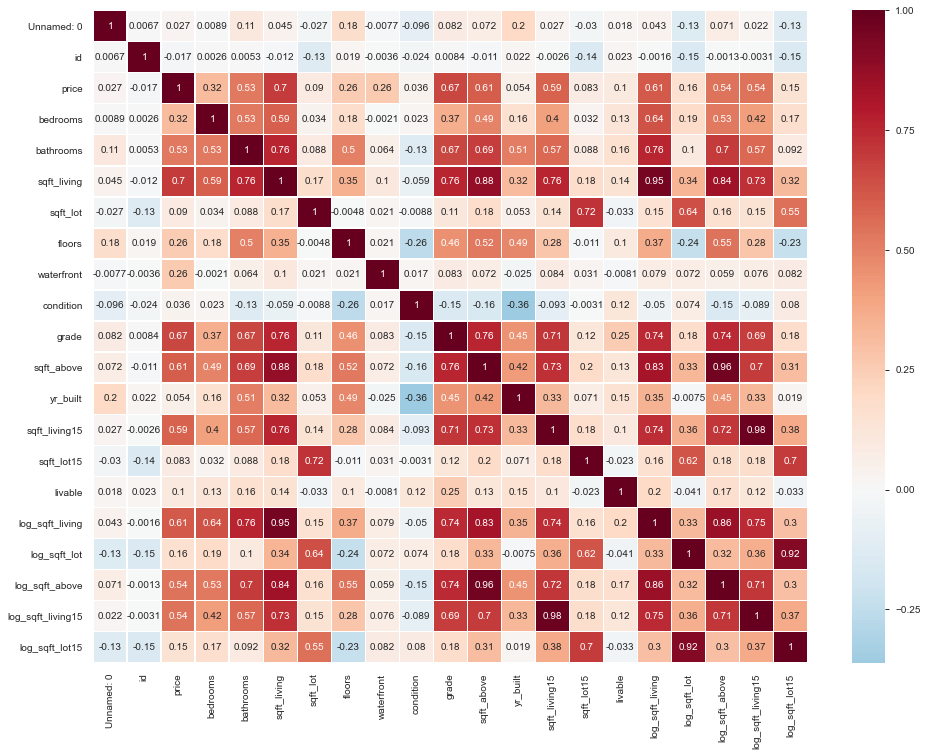

In [154]:
#create correlation heatmap to visualize collinearity
plt.figure(figsize=(16,12))
pcorr2 = kchouse_model2.corr()
cmap = 'RdBu_r'
sns.heatmap(pcorr2, 
            xticklabels=pcorr2.columns, 
            yticklabels=pcorr2.columns,
            cmap=cmap,
            annot=True,
            linewidth=0.5,
            center=0)

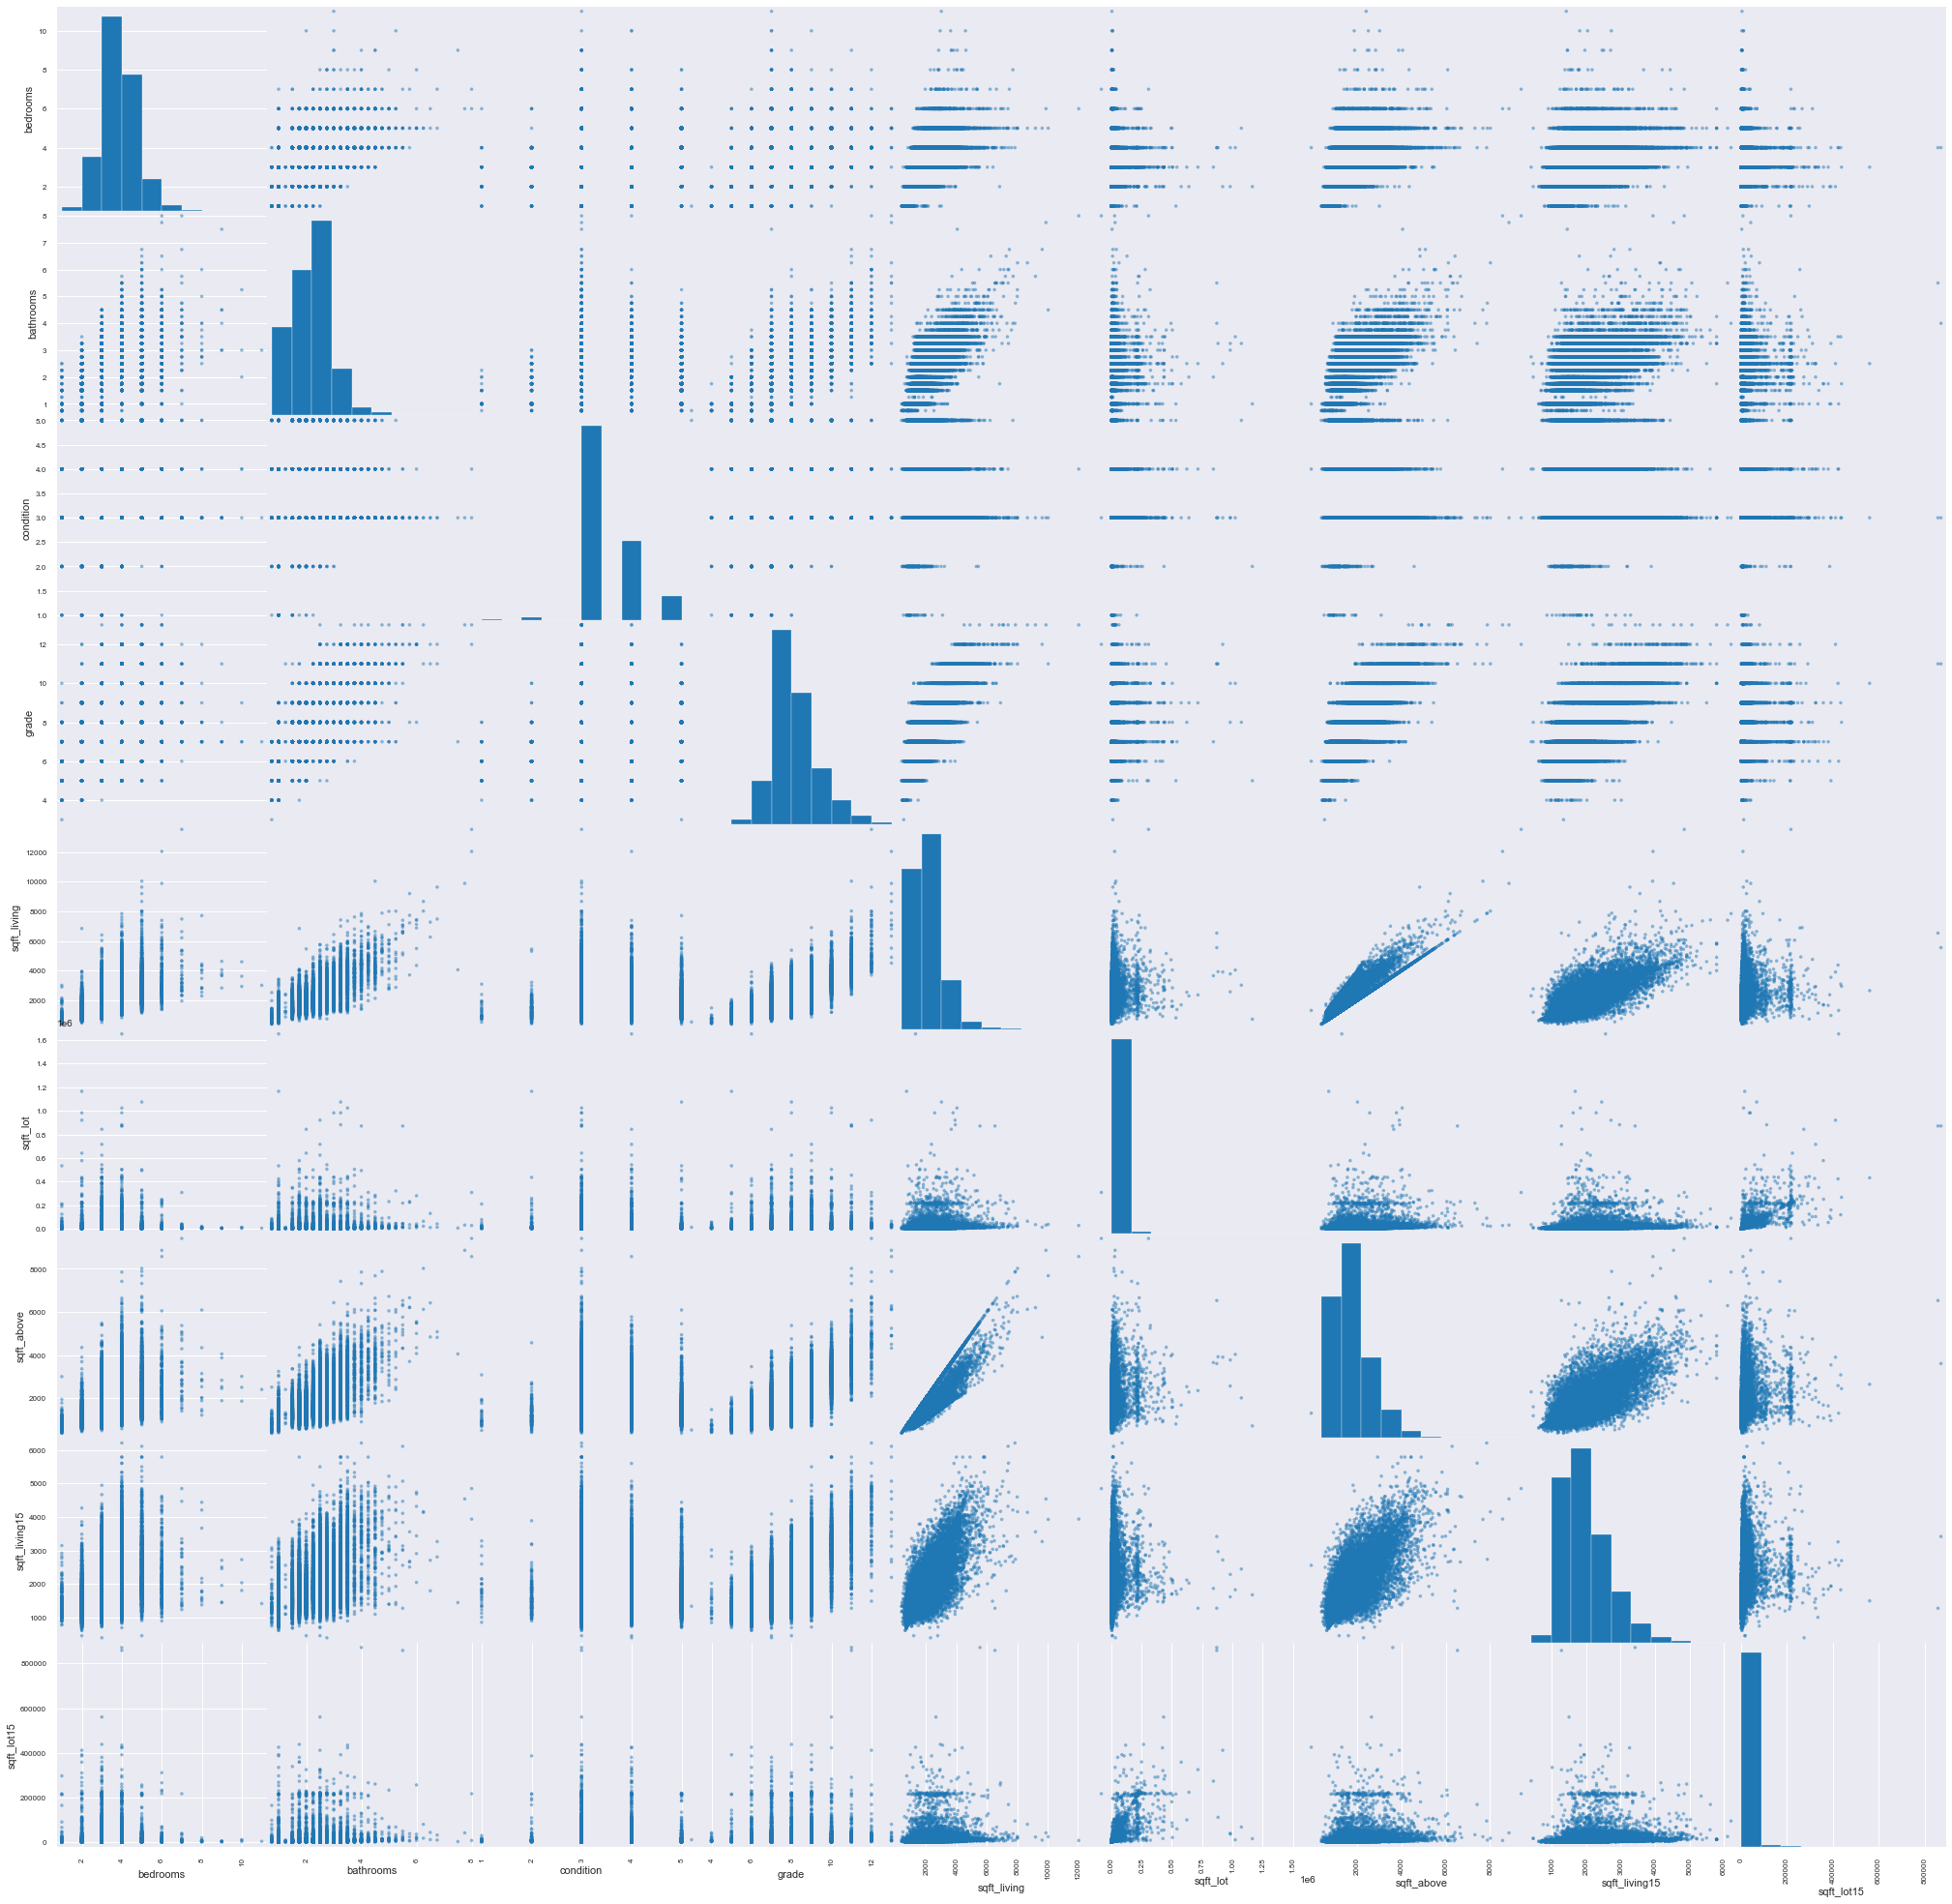

In [128]:
#create a scatterplot matrix of select predictor variables
pred2 = ['bedrooms', 'bathrooms', 'condition', 'grade', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']
kchouse_pred2 = kchouse_model2[pred2]
pd.plotting.scatter_matrix(kchouse_pred2,figsize  = [35, 35]);
plt.show()

In [129]:
#call correlation stats for predictor variables
kchouse_pred2.corr()

bedrooms            bathrooms             condition  \
bedrooms                       1.0   0.5277530348839268  0.023361266929830916   
bathrooms       0.5277530348839268                  1.0  -0.12663229943418733   
condition     0.023361266929830916 -0.12663229943418733                   1.0   
grade          0.36592047931946037   0.6657850106118681  -0.14697345489897545   
sqft_living     0.5930704528451498   0.7558028068252324 -0.059492615409995384   
sqft_lot       0.03355713927979069  0.08831875811818539 -0.008844503757280232   
sqft_above     0.49235180877493234   0.6866861088450199  -0.15894608097200708   
sqft_living15  0.40447062104062526   0.5698914389758228  -0.09309287336351725   
sqft_lot15     0.03184102972465294  0.08824054749091677  -0.00314598072269266   

                             grade           sqft_living  \
bedrooms       0.36592047931946037    0.5930704528451498   
bathrooms       0.6657850106118681    0.7558028068252324   
condition     -0.14697345489897545 -0.059492615409995384   
grade                          1.0    0.7627126593347316   
sqft_living     0.7627126593347316                   1.0   
sqft_lot       0.11470531554278934   0.17343524208911373   
sqft_above      0.7559987778994303    0.8764227017048802   
sqft_living15   0.7138776260739129     0.756395249409493   
sqft_lot15     0.12094848112373817    0.1843198739355178   

                           sqft_lot           sqft_above        sqft_living15  \
bedrooms        0.03355713927979069  0.49235180877493234  0.40447062104062526   
bathrooms       0.08831875811818539   0.6866861088450199   0.5698914389758228   
condition     -0.008844503757280232 -0.15894608097200708 -0.09309287336351725   
grade           0.11470531554278934   0.7559987778994303   0.7138776260739129   
sqft_living     0.17343524208911373   0.8764227017048802    0.756395249409493   
sqft_lot                        1.0  0.18412830751951284  0.14474166804821595   
sqft_above      0.18412830751951284                  1.0   0.7317643428556784   
sqft_living15   0.14474166804821595   0.7317643428556784                  1.0   
sqft_lot15       0.7182009201496592  0.19506273888793474  0.18349440964483835   

                        sqft_lot15  
bedrooms       0.03184102972465294  
bathrooms      0.08824054749091677  
condition     -0.00314598072269266  
grade          0.12094848112373817  
sqft_living     0.1843198739355178  
sqft_lot        0.7182009201496592  
sqft_above     0.19506273888793474  
sqft_living15  0.18349440964483835  
sqft_lot15                     1.0

In [130]:
#generate matrix of predictor collinearity greater than .7
abs(kchouse_pred2.corr()) > 0.7

bedrooms  bathrooms  condition  grade  sqft_living  sqft_lot  \
bedrooms           True      False      False  False        False     False   
bathrooms         False       True      False  False         True     False   
condition         False      False       True  False        False     False   
grade             False      False      False   True         True     False   
sqft_living       False       True      False   True         True     False   
sqft_lot          False      False      False  False        False      True   
sqft_above        False      False      False   True         True     False   
sqft_living15     False      False      False   True         True     False   
sqft_lot15        False      False      False  False        False      True   

               sqft_above  sqft_living15  sqft_lot15  
bedrooms            False          False       False  
bathrooms           False          False       False  
condition           False          False       False  
grade                True           True       False  
sqft_living          True           True       False  
sqft_lot            False          False        True  
sqft_above           True           True       False  
sqft_living15        True           True       False  
sqft_lot15          False          False        True

### Model 2 Validation - Train_Test_Split

In [131]:
data2 = kchouse_model2
y2 = data2['price']
X2 = data2.drop(['city'], axis = 1)

In [132]:
# create data sets with an 80/20 split - train/test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2)

In [133]:
len(y2_test)

4319

In [134]:
#MSE of train and validation data sets
linreg = LinearRegression()
linreg.fit(X2_train, y2_train)

y2_hat_train = linreg.predict(X2_train)
y2_hat_test = linreg.predict(X2_test)

mse_train2 = np.sum((y2_train-y2_hat_train)**2)/len(y2_train)
mse_test2 =np.sum((y2_test-y2_hat_test)**2)/len(y2_test)
print('Train Mean Squarred Error:', mse_train2)
print('Test Mean Squarred Error:', mse_test2)

Train Mean Squarred Error: 1.5903602585255162e-18
Test Mean Squarred Error: 1.6260684076158842e-18


In [135]:
#RMSE of train and validation data sets
rmse_train2 = np.sqrt(mse_train2)
rmse_test2 = np.sqrt(mse_test2)
print('Train Root Mean Squarred Error:', rmse_train2)
print('Test Root Mean Squarred Error:', rmse_test2)

Train Root Mean Squarred Error: 1.2610948649984727e-09
Test Root Mean Squarred Error: 1.2751738734838808e-09


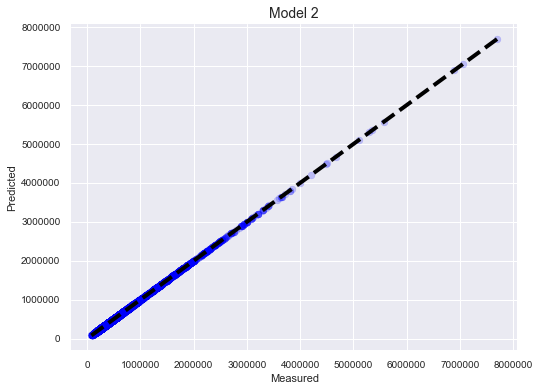

In [186]:
#plot cross-validation predictions
predicted2 = cross_val_predict(linreg, X2, y2, cv=10)

fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(y2, predicted2, alpha=0.2, color='blue')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Model 2', size=14)
ax.ticklabel_format(style='plain')
plt.show()

<AxesSubplot:xlabel='price'>

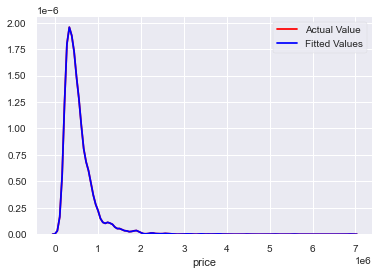

In [138]:
ax1 = sns.distplot(y2_test, hist=False, color="r", label="Actual Value")
sns.distplot(y2_hat_test, hist=False, color="b", label="Fitted Values" , ax=ax1)

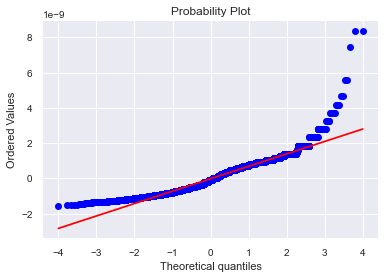

In [109]:
#check distribution of residuals using probability plot 
base_X2 = X2
base_y2_predicted = linreg.predict(base_X2)
base_residuals2 = y2 - base_y2_predicted

_ = probplot(base_residuals2, plot=plt)

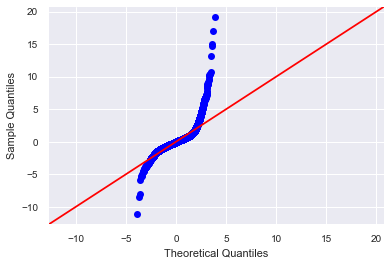

In [110]:
#check normality of residuals using Q-Q plot
fig = sm.graphics.qqplot(model2.resid, dist=stats.norm, line='45', fit=True)

#### Observations: R-squared a .753. Better RSME between test and train data sets with a good fit.

## Model 3 - Affordable, Livable
Refining model to focus on first-time home buyers looking at relative affordability in livable, and move-in ready homes

In [111]:
#dropping houses that do not meet building codes and are not habitable, i.e. livable
kchouse_model3 = kchouse_model2.drop(kchouse_model2[kchouse_model2.livable != 1].index)

In [112]:
#call descriptive stats grouped by city by price
kchouse_model3.groupby('city')['price'].describe()

count                 mean                  std       min  \
city                                                                        
Auburn          880.0  294,128.60113636364  106,679.46941476356  90,000.0   
Bellevue      1,400.0   899,834.8421428571   560,230.7603271421 247,500.0   
Black Diamond    94.0  434,164.42553191487  195,994.56793770022 135,000.0   
Bothell         194.0  491,513.07216494845  121,247.76419550701 245,500.0   
Carnation       111.0   479,993.4414414414  259,153.10204368958 134,000.0   
Duvall          186.0  429,082.59139784944  127,982.60069972236 170,000.0   
Enumclaw        227.0   318,984.9207048458  122,644.76994582557 122,000.0   
Fall City        76.0   604,456.1842105263   377,620.8599560044 212,000.0   
Federal Way     768.0   290,346.7721354167  108,688.32367260187  86,500.0   
Issaquah        724.0    618,899.935082873  259,420.26681944518 240,000.0   
Kenmore         281.0  464,193.41637010674  148,664.21679272343 160,000.0   
Kent          1,178.0   300,776.1349745331     90,587.121237119  85,000.0   
Kirkland        969.0   647,645.8637770897   410,782.1436454994  90,000.0   
Maple Valley    586.0   367,547.5836177474  132,784.75225257137 110,000.0   
Medina           50.0          2,161,300.0 1,166,904.3994908154 787,500.0   
Mercer Island   280.0 1,198,326.3071428572   608,511.6127893095 500,000.0   
North Bend      212.0   446,505.2311320755  208,558.15500833784 175,000.0   
Redmond         973.0   658,693.5714285715   230,311.5470154872 225,000.0   
Renton        1,526.0   411,080.4711664482  201,391.32172867117 129,000.0   
Sammamish       795.0   734,527.4918238993  280,676.66649988387 310,000.0   
Seattle       8,770.0   540,758.8019384264   340,769.6933756568  82,000.0   
Snoqualmie      296.0    539,232.847972973  181,827.61579921696 190,000.0   
Vashon          108.0  504,766.31481481483   199,912.4249075195 230,000.0   
Woodinville     470.0   618,279.7808510638    243,967.279448464 200,000.0   

                      25%         50%         75%         max  
city                                                           
Auburn          225,000.0   272,000.0   335,000.0   930,000.0  
Bellevue        550,825.0   749,475.0  999,999.25 7,060,000.0  
Black Diamond   262,375.0   372,000.0   611,250.0   935,000.0  
Bothell         414,000.0   470,000.0   550,000.0 1,080,000.0  
Carnation       321,500.0   425,000.0   554,975.0 1,680,000.0  
Duvall          331,969.0   404,625.0   500,000.0 1,020,000.0  
Enumclaw        238,250.0   280,017.0   351,500.0   858,000.0  
Fall City       365,875.0   472,500.0   712,500.0 1,860,000.0  
Federal Way     226,687.5   268,750.0   320,000.0 1,280,000.0  
Issaquah       472,429.25   575,000.0   699,237.5 2,700,000.0  
Kenmore         380,000.0   446,000.0   526,750.0 1,600,000.0  
Kent            245,000.0   284,500.0   340,000.0   859,000.0  
Kirkland        425,000.0   512,500.0   740,000.0 5,110,000.0  
Maple Valley    287,050.0   342,250.0   410,750.0 1,350,000.0  
Medina        1,402,500.0 1,895,000.0 2,560,000.0 6,890,000.0  
Mercer Island   828,750.0   994,500.0 1,390,000.0 5,300,000.0  
North Bend      309,046.5   421,000.0  499,570.75 1,950,000.0  
Redmond         500,000.0   625,000.0   766,000.0 2,280,000.0  
Renton          299,237.5   361,000.0   468,750.0 3,000,000.0  
Sammamish       569,750.0   690,000.0   830,774.0 3,200,000.0  
Seattle         342,000.0   459,000.0   635,000.0 7,700,000.0  
Snoqualmie      427,397.5   512,500.0   623,462.5 2,000,000.0  
Vashon          357,250.0   480,000.0   588,750.0 1,380,000.0  
Woodinville     445,500.0   570,000.0  752,143.75 1,920,000.0

In [113]:
kchouse_model3.describe()

Unnamed: 0                    id              price  \
count            21,154.0              21,154.0           21,154.0   
mean  10,814.713765718068  4,589,644,665.462371 545,645.0036872459   
std    6,245.525198117761 2,876,384,130.6781135 368,274.9340263089   
min                   0.0           1,000,102.0           82,000.0   
25%              5,406.25      2,126,049,044.75          325,000.0   
50%              10,806.5       3,905,040,120.0          455,000.0   
75%             16,224.75       7,334,401,347.5          650,000.0   
max              21,596.0       9,900,000,190.0        7,700,000.0   

                bedrooms          bathrooms         sqft_living  \
count           21,154.0           21,154.0            21,154.0   
mean  3.3892408055214145 2.1341117519145314 2,099.6107591944788   
std   0.8931734251671364 0.7632719231927677   914.1910120402173   
min                  1.0               0.75               390.0   
25%                  3.0               1.75             1,440.0   
50%                  3.0               2.25             1,930.0   
75%                  4.0                2.5             2,569.5   
max                 11.0                8.0            13,540.0   

                 sqft_lot             floors           waterfront  \
count            21,154.0           21,154.0             21,154.0   
mean  14,904.985061926822 1.5019381677224166 0.006665406069774038   
std    40,438.18255153015 0.5411677220910746  0.08137131826342073   
min                 520.0                1.0                  0.0   
25%               5,038.5                1.0                  0.0   
50%               7,615.0                1.5                  0.0   
75%              10,637.0                2.0                  0.0   
max           1,651,359.0                3.5                  1.0   

               condition              grade          sqft_above  \
count           21,154.0           21,154.0            21,154.0   
mean  3.4213860262834452  7.700765812612272 1,803.6953294885127   
std   0.6335222156012758 1.1369564444993843    827.028809530843   
min                  3.0                6.0               390.0   
25%                  3.0                7.0             1,200.0   
50%                  3.0                7.0             1,580.0   
75%                  4.0                8.0             2,230.0   
max                  5.0               13.0             9,410.0   

                yr_built       sqft_living15          sqft_lot15  livable  \
count           21,154.0            21,154.0            21,154.0 21,154.0   
mean  1,971.640162616999 1,997.0585232107403  12,669.27219438404      1.0   
std   29.167048644032306   685.4511679350451 26,988.590651477763      0.0   
min              1,900.0               399.0               651.0      1.0   
25%              1,952.0             1,500.0             5,100.0      1.0   
50%              1,976.0             1,850.0             7,620.0      1.0   
75%              1,997.0             2,370.0           10,069.75      1.0   
max              2,015.0             6,210.0           871,200.0      1.0   

         log_sqft_living       log_sqft_lot      log_sqft_above  \
count           21,154.0           21,154.0            21,154.0   
mean   7.563086642508571  8.984593459469192   7.405638153493975   
std   0.4152529181150659 0.8989856465168691 0.42156236687486975   
min    5.966146739123692  6.253828811575472   5.966146739123692   
25%   7.2723983925700475   8.52486368295077   7.090076835776093   
50%   7.5652752818989315  8.937875265329263   7.365180126021014   
75%    7.851466549619412  9.272093768251665   7.709756864454165   
max    9.513403546466266 14.317109143238099   9.149528232579426   

        log_sqft_living15     log_sqft_lot15  
count            21,154.0           21,154.0  
mean    7.545249044172711  8.956960325797425  
std   0.32591285977015294  0.811738771218576  
min     5.988961416889863  6.478509642208568  
25%    7.313220387090

In [114]:
eda_table(kchouse_model3)

null_sum  null_prct   dtypes  count                 mean  \
Unnamed: 0                0        0.0    int64  21154  10,814.713765718068   
bathrooms                 0        0.0  float64  21154   2.1341117519145314   
bedrooms                  0        0.0    int64  21154   3.3892408055214145   
city                      0        0.0   object  21154                  nan   
condition                 0        0.0    int64  21154   3.4213860262834452   
floors                    0        0.0  float64  21154   1.5019381677224166   
grade                     0        0.0    int64  21154    7.700765812612272   
id                        0        0.0    int64  21154 4,589,644,665.462371   
livable                   0        0.0    int64  21154                  1.0   
log_sqft_above            0        0.0  float64  21154    7.405638153493975   
log_sqft_living           0        0.0  float64  21154    7.563086642508571   
log_sqft_living15         0        0.0  float64  21154    7.545249044172711   
log_sqft_lot              0        0.0  float64  21154    8.984593459469192   
log_sqft_lot15            0        0.0  float64  21154    8.956960325797425   
price                     0        0.0  float64  21154   545,645.0036872459   
sqft_above                0        0.0    int64  21154  1,803.6953294885127   
sqft_living               0        0.0    int64  21154  2,099.6107591944788   
sqft_living15             0        0.0    int64  21154  1,997.0585232107403   
sqft_lot                  0        0.0    int64  21154  14,904.985061926822   
sqft_lot15                0        0.0    int64  21154   12,669.27219438404   
waterfront                0        0.0  float64  21154 0.006665406069774038   
yr_built                  0        0.0    int64  21154   1,971.640162616999   

                              median               min                max  
Unnamed: 0                  10,806.5                 0              21596  
bathrooms                       2.25              0.75                8.0  
bedrooms                         3.0                 1                 11  
city                             nan            Auburn        Woodinville  
condition                        3.0                 3                  5  
floors                           1.5               1.0                3.5  
grade                            7.0                 6                 13  
id                   3,905,040,120.0           1000102         9900000190  
livable                          1.0                 1                  1  
log_sqft_above     7.365180126021014 5.966146739123692  9.149528232579426  
log_sqft_living   7.5652752818989315 5.966146739123692  9.513403546466266  
log_sqft_living15   7.52294091807237 5.988961416889863  8.733916174927524  
log_sqft_lot       8.937875265329263 6.253828811575472 14.317109143238099  
log_sqft_lot15     8.938531648680692 6.478509642208568 13.677626850600886  
price                      455,000.0          82,000.0        7,700,000.0  
sqft_above                   1,580.0               390               9410  
sqft_living                  1,930.0               390              13540  
sqft_living15                1,850.0               399               6210  
sqft_lot                     7,615.0               520            1651359  
sqft_lot15                   7,620.0               651             871200  
waterfront                       0.0               0.0                1.0  
yr_built                     1,976.0              1900               2015

### OLS - Model 3

In [139]:
data = kchouse_model3
target = 'price'
x_cols = kchouse_model3.drop([target,'id'], axis=1).columns
predictors = '+'.join(x_cols)
f = target + '~' + predictors

model3 = smf.ols(formula=f, data=data).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     1609.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:26:16   Log-Likelihood:            -2.8635e+05
No. Observations:               21154   AIC:                         5.728e+05
Df Residuals:                   21113   BIC:                         5.731e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.254e+06   9.32e+04     34.931      0.000    3.07e+06    3.44e+06
city[T.Bellevue]       3.291e+05   8149.048     40.382      0.000    3.13e+05    3.45e+05
city[T.Black Diamond]  9.756e+04      2e+04      4.880      0.000    5.84e+04    1.37e+05
city[T.Bothell]        1.085e+05   1.46e+04      7.438      0.000    7.99e+04    1.37e+05
city[T.Carnation]      1.269e+05   1.88e+04      6.763      0.000    9.01e+04    1.64e+05
city[T.Duvall]         1.056e+05   1.49e+04      7.107      0.000    7.65e+04    1.35e+05
city[T.Enumclaw]       3.421e+04   1.38e+04      2.478      0.013    7146.820    6.13e+04
city[T.Fall City]      1.726e+05   2.22e+04      7.773      0.000    1.29e+05    2.16e+05
city[T.Federal Way]   -3.107e+04   9090.636     -3.418      0.001   -4.89e+04   -1.33e+04
city[T.Issaquah]       1.404e+05   9307.719     15.082      0.000    1.22e+05    1.59e+05
city[T.Kenmore]        1.123e+05   1.26e+04      8.911      0.000    8.76e+04    1.37e+05
city[T.Kent]           7307.0380   8176.095      0.894      0.371   -8718.732    2.33e+04
city[T.Kirkland]       2.541e+05   8603.974     29.531      0.000    2.37e+05    2.71e+05
city[T.Maple Valley]    4.12e+04   9826.278      4.193      0.000    2.19e+04    6.05e+04
city[T.Medina]         1.184e+06    2.7e+04     43.916      0.000    1.13e+06    1.24e+06
city[T.Mercer Island]  4.352e+05   1.29e+04     33.666      0.000     4.1e+05    4.61e+05
city[T.North Bend]     1.202e+05   1.41e+04      8.516      0.000    9.25e+04    1.48e+05
city[T.Redmond]        1.944e+05   8619.075     22.550      0.000    1.77e+05    2.11e+05
city[T.Renton]         5.071e+04   7787.657      6.511      0.000    3.54e+04     6.6e+04
city[T.Sammamish]      1.298e+05   9228.533     14.064      0.000    1.12e+05    1.48e+05
city[T.Seattle]        1.829e+05   6998.256     26.133      0.000    1.69e+05    1.97e+05
city[T.Snoqualmie]     7.478e+04   1.25e+04      5.980      0.000    5.03e+04    9.93e+04
city[T.Vashon]         7.676e+04   1.92e+04      3.991      0.000    3.91e+04    1.14e+05
city[T.Woodinville]    1.247e+05   1.07e+04     11.676      0.000    1.04e+05    1.46e+05
bedrooms              -1.979e+04   1912.501    -10.346      0.000   -2.35e+04    -1.6e+04
bathrooms              4.909e+04   3013.233     16.293      0.000    4.32e+04     5.5e+04
sqft_living             371.7662      8.569     43.385      0.000     354.970     388.562
sqft_lot                  0.2385      0.056      4.282      0.000       0.129       0.348
floors                 6787.7251   3863.049      1.757      0.079    -784.146    1.44e+04
waterfront             7.482e+05   1.59e+04     47.064      0.000    7.17e+05    7.79e+05
condition              2.957e+04   2256.747     13.102      0.000    2.51e+04     3.4e+04
grade                  

### Multicollinearity

<AxesSubplot:>

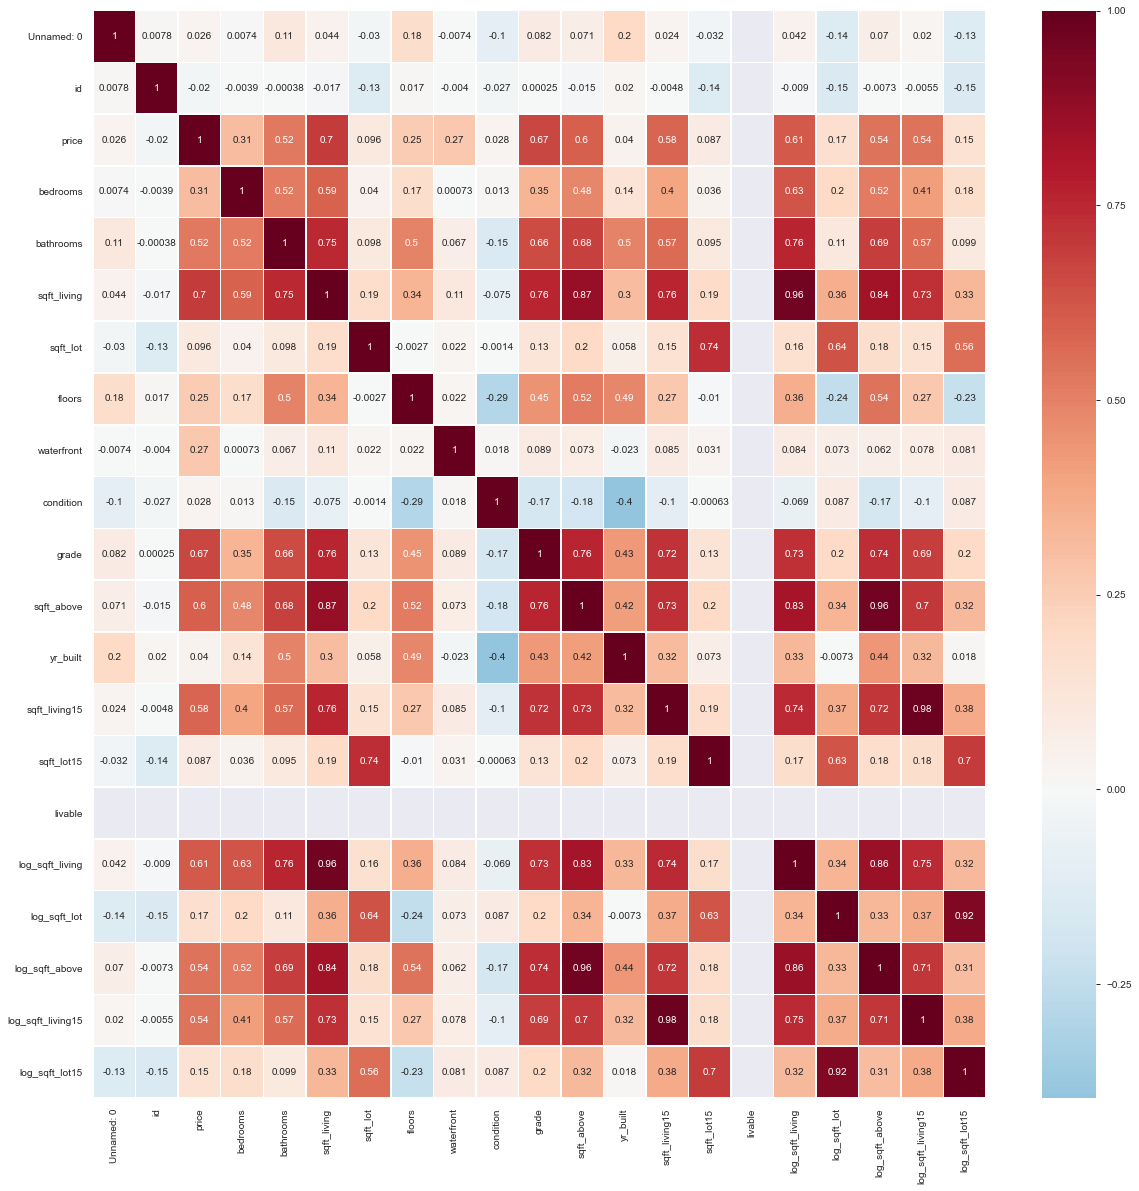

In [198]:
#create correlation heatmap to visualize collinearity
plt.figure(figsize=(20,20))
pcorr3 = kchouse_model3.corr()
cmap = 'RdBu_r'
sns.heatmap(pcorr3, 
            xticklabels=pcorr3.columns, 
            yticklabels=pcorr3.columns,
            cmap=cmap,
            annot=True,
            linewidth=0.5,
            center=0)

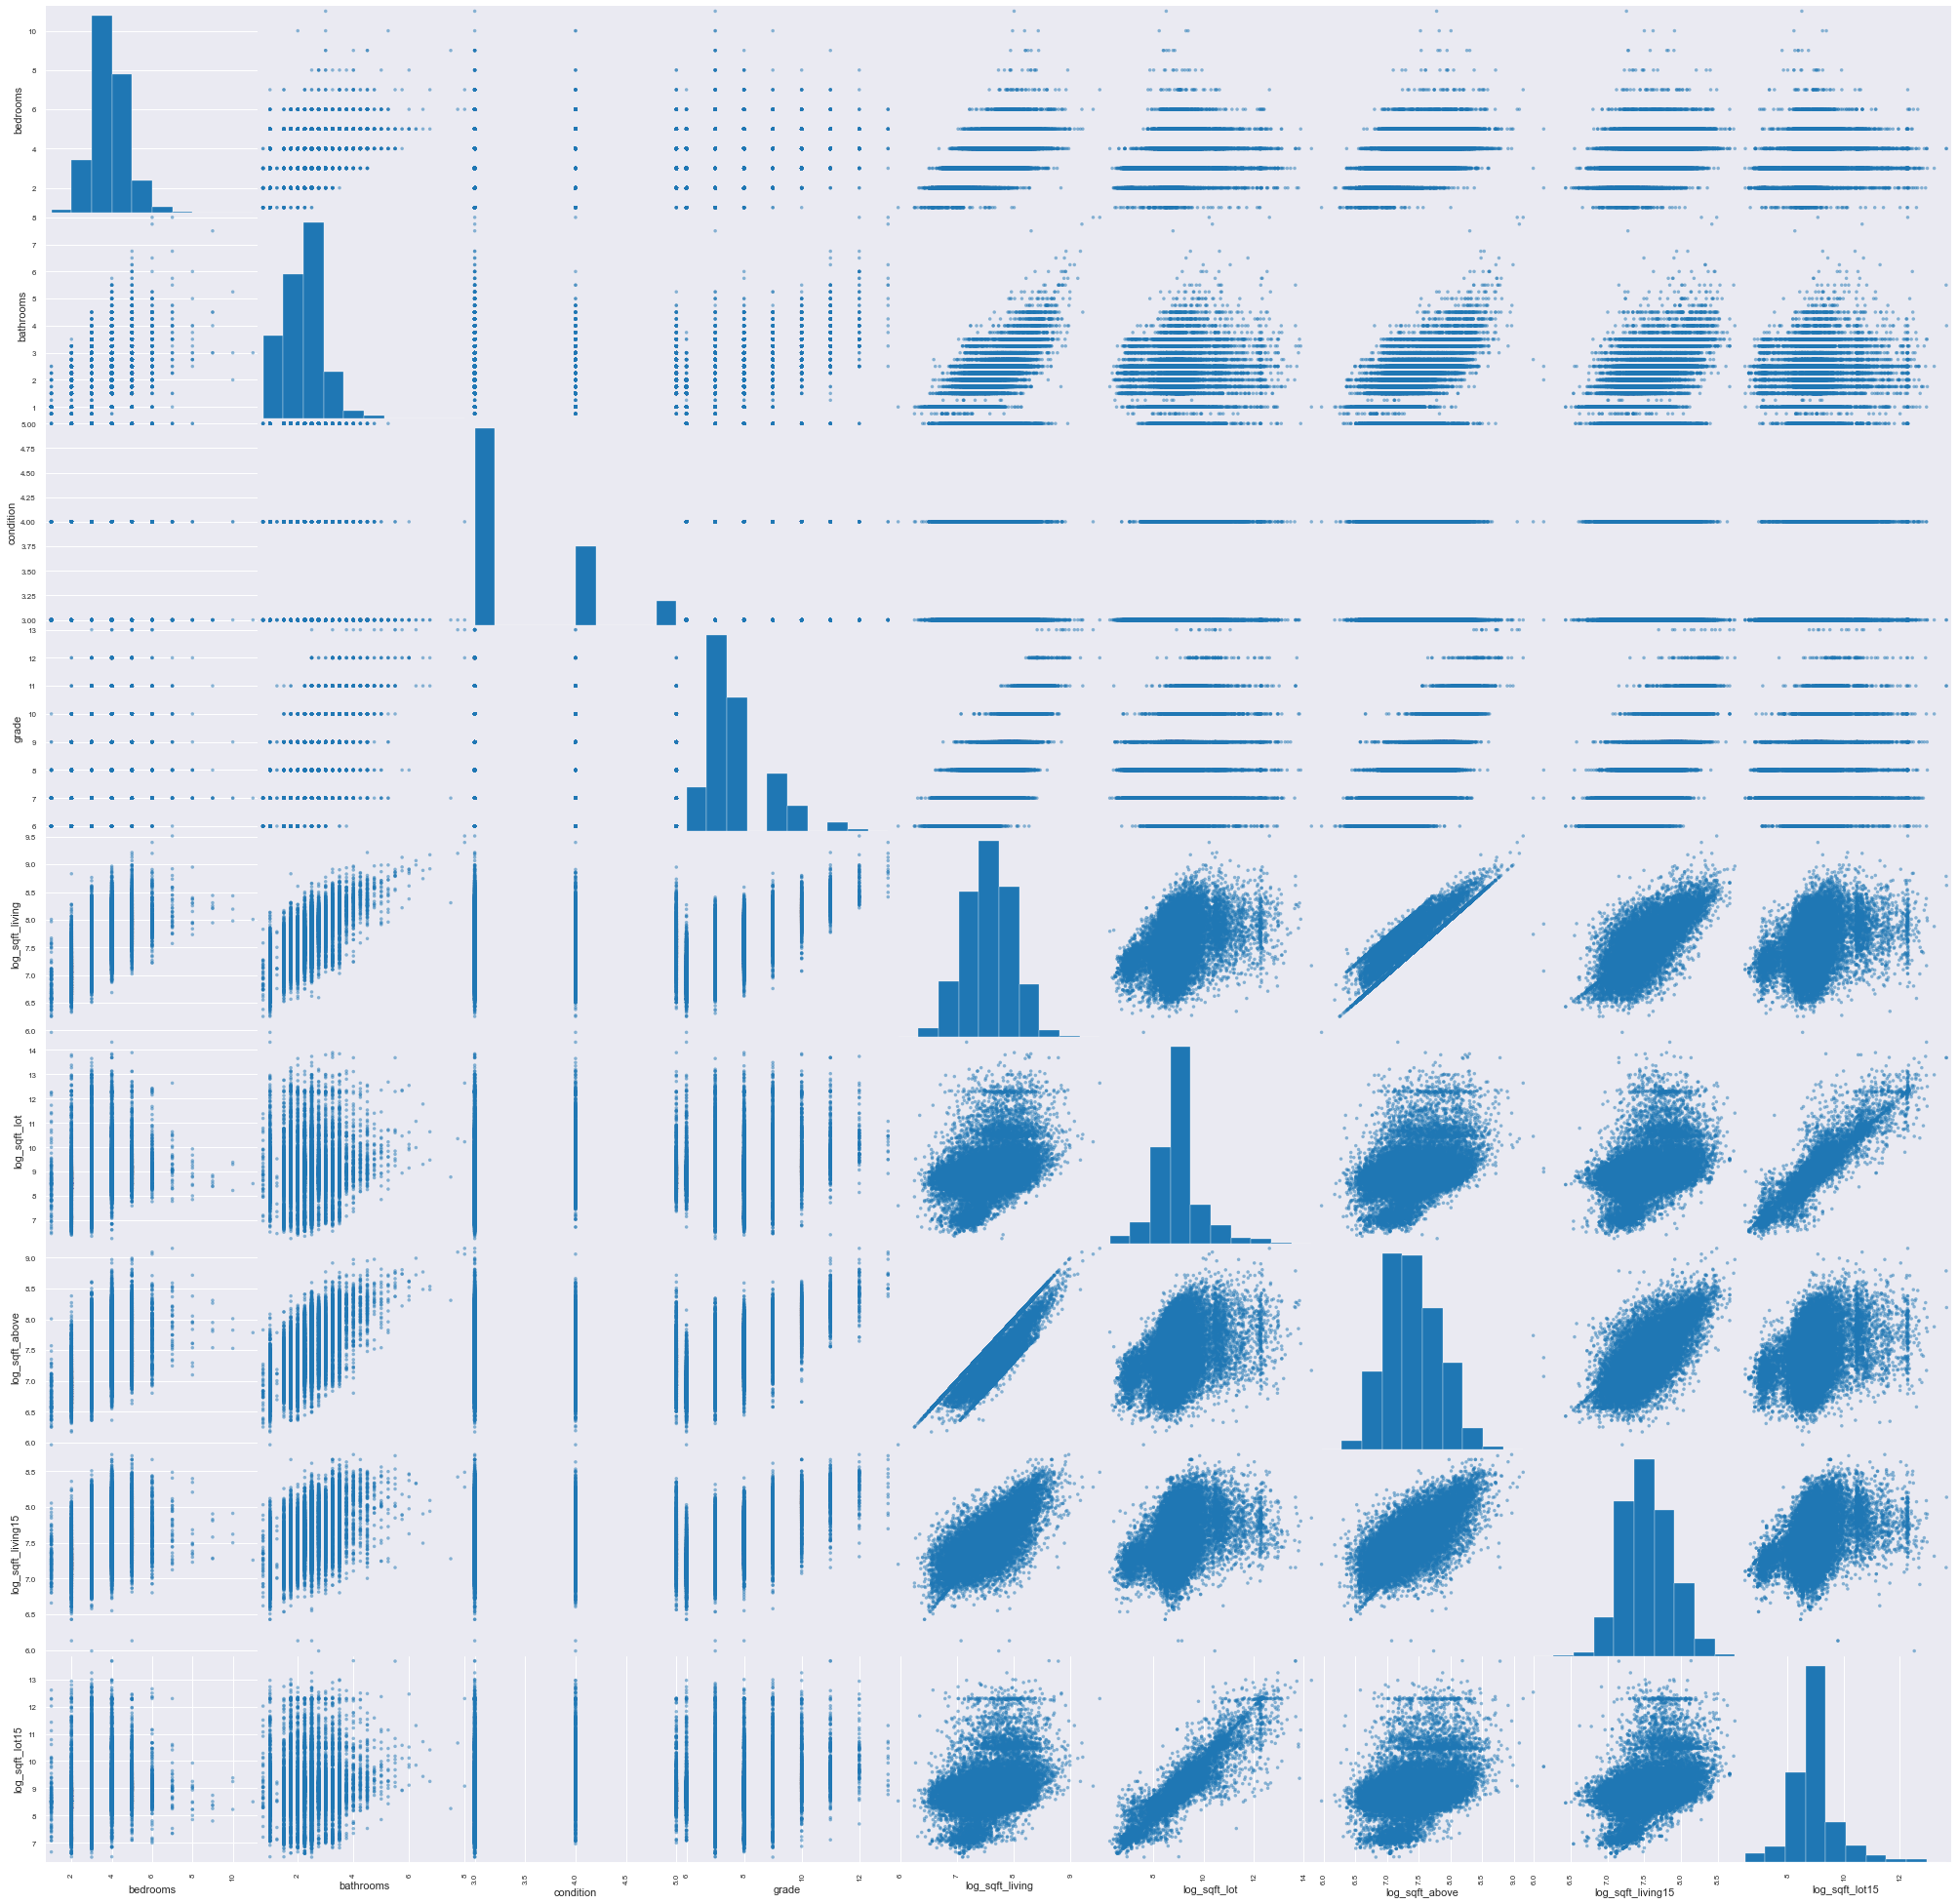

In [141]:
#create a scatterplot matrix of select predictor variables
pred3 = ['bedrooms', 'bathrooms', 'condition', 'grade', 'log_sqft_living', 'log_sqft_lot', 'log_sqft_above', 'log_sqft_living15', 'log_sqft_lot15']
kchouse_pred3 = kchouse_model3[pred3]
pd.plotting.scatter_matrix(kchouse_pred3,figsize  = [35, 35]);
plt.show()

In [142]:
#call correlation stats for predictor variables
kchouse_pred3.corr()

bedrooms            bathrooms  \
bedrooms                           1.0   0.5186268109278765   
bathrooms           0.5186268109278765                  1.0   
condition         0.013393192800361782 -0.14950560554422346   
grade              0.34527926599559305   0.6559819710995161   
log_sqft_living     0.6267222888364788   0.7569232060306649   
log_sqft_lot       0.19997895612701735  0.10933924944081799   
log_sqft_above      0.5160782469461855   0.6891638627196358   
log_sqft_living15    0.411943932838321   0.5666240218696617   
log_sqft_lot15      0.1754791400108726  0.09944961354892616   

                             condition               grade  \
bedrooms          0.013393192800361782 0.34527926599559305   
bathrooms         -0.14950560554422346  0.6559819710995161   
condition                          1.0  -0.173246642268762   
grade               -0.173246642268762                 1.0   
log_sqft_living    -0.0694625136747308  0.7320403186151675   
log_sqft_lot       0.08692119326631338   0.203015034694262   
log_sqft_above    -0.17377561157769794  0.7366453061508367   
log_sqft_living15 -0.10126659216751745  0.6907556130545249   
log_sqft_lot15     0.08715075614644927 0.20254372842425195   

                      log_sqft_living        log_sqft_lot  \
bedrooms           0.6267222888364788 0.19997895612701735   
bathrooms          0.7569232060306649 0.10933924944081799   
condition         -0.0694625136747308 0.08692119326631338   
grade              0.7320403186151675   0.203015034694262   
log_sqft_living                   1.0 0.34381748198996953   
log_sqft_lot      0.34381748198996953                 1.0   
log_sqft_above     0.8594475003394693 0.33201068889995594   
log_sqft_living15  0.7485447509688984 0.37119927338101016   
log_sqft_lot15    0.31901987254885217  0.9217132717746014   

                        log_sqft_above    log_sqft_living15  \
bedrooms            0.5160782469461855    0.411943932838321   
bathrooms           0.6891638627196358   0.5666240218696617   
condition         -0.17377561157769794 -0.10126659216751745   
grade               0.7366453061508367   0.6907556130545249   
log_sqft_living     0.8594475003394693   0.7485447509688984   
log_sqft_lot       0.33201068889995594  0.37119927338101016   
log_sqft_above                     1.0   0.7125580994711993   
log_sqft_living15   0.7125580994711993                  1.0   
log_sqft_lot15     0.31074668515670734   0.3808149026311399   

                       log_sqft_lot15  
bedrooms           0.1754791400108726  
bathrooms         0.09944961354892616  
condition         0.08715075614644927  
grade             0.20254372842425195  
log_sqft_living   0.31901987254885217  
log_sqft_lot       0.9217132717746014  
log_sqft_above    0.31074668515670734  
log_sqft_living15  0.3808149026311399  
log_sqft_lot15                    1.0

In [143]:
#generate matrix of predictor collinearity greater than .7
abs(kchouse_pred3.corr()) > 0.7

bedrooms  bathrooms  condition  grade  log_sqft_living  \
bedrooms               True      False      False  False            False   
bathrooms             False       True      False  False             True   
condition             False      False       True  False            False   
grade                 False      False      False   True             True   
log_sqft_living       False       True      False   True             True   
log_sqft_lot          False      False      False  False            False   
log_sqft_above        False      False      False   True             True   
log_sqft_living15     False      False      False  False             True   
log_sqft_lot15        False      False      False  False            False   

                   log_sqft_lot  log_sqft_above  log_sqft_living15  \
bedrooms                  False           False              False   
bathrooms                 False           False              False   
condition                 False           False              False   
grade                     False            True              False   
log_sqft_living           False            True               True   
log_sqft_lot               True           False              False   
log_sqft_above            False            True               True   
log_sqft_living15         False            True               True   
log_sqft_lot15             True           False              False   

                   log_sqft_lot15  
bedrooms                    False  
bathrooms                   False  
condition                   False  
grade                       False  
log_sqft_living             False  
log_sqft_lot                 True  
log_sqft_above              False  
log_sqft_living15           False  
log_sqft_lot15               True

In [144]:
data3 = kchouse_model3
y3 = data3['price']
X3 = data3.drop(['city'], axis = 1)

In [145]:
# create data sets with an 80/20 split - train/test
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2)

In [146]:
len(y3_test)

4231

In [147]:
#MSE of train and validation data sets
linreg = LinearRegression()
linreg.fit(X3_train, y3_train)

y3_hat_train = linreg.predict(X3_train)
y3_hat_test = linreg.predict(X3_test)

mse_train3 = np.sum((y3_train-y3_hat_train)**2)/len(y3_train)
mse_test3 =np.sum((y3_test-y3_hat_test)**2)/len(y3_test)
print('Train Mean Squarred Error:', mse_train3)
print('Test Mean Squarred Error:', mse_test3)

Train Mean Squarred Error: 5.7471005283376465e-19
Test Mean Squarred Error: 5.48622399109766e-19


In [148]:
#RMSE of train and validation data sets
rmse_train3 = np.sqrt(mse_train3)
rmse_test3 = np.sqrt(mse_test3)
print('Train Root Mean Squarred Error:', rmse_train3)
print('Test Root Mean Squarred Error:', rmse_test3)

Train Root Mean Squarred Error: 7.580963347977384e-10
Test Root Mean Squarred Error: 7.406904880648638e-10


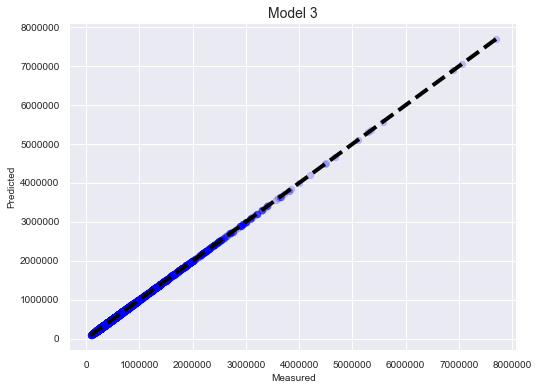

In [196]:
#plot cross-validation predictions
predicted3 = cross_val_predict(linreg, X3, y3, cv=10)

fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(y3, predicted3, alpha=0.2, color='blue')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured', size=10)
ax.set_ylabel('Predicted', size=10)
ax.set_title('Model 3', size=14)
ax.ticklabel_format(style='plain')
plt.show()

<AxesSubplot:xlabel='price'>

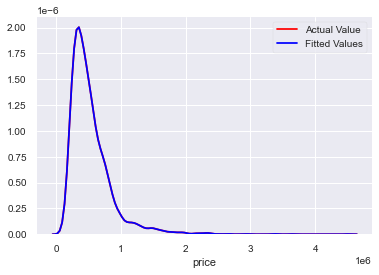

In [150]:
ax1 = sns.distplot(y3_test, hist=False, color="r", label="Actual Value")
sns.distplot(y3_hat_test, hist=False, color="b", label="Fitted Values" , ax=ax1)

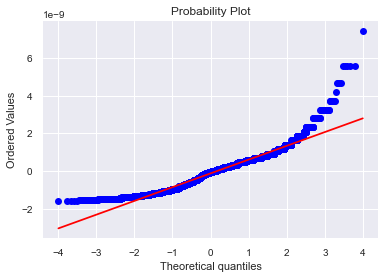

In [151]:
#check distribution of residuals using probability plot 
base_X3 = X3
base_y3_predicted = linreg.predict(base_X3)
base_residuals3 = y3 - base_y3_predicted

_ = probplot(base_residuals3, plot=plt)

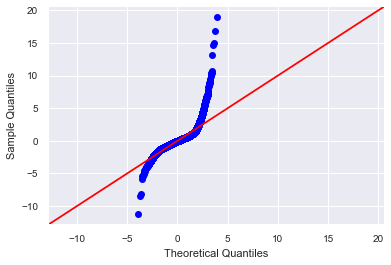

In [152]:
#check normality of residuals using Q-Q plot
fig = sm.graphics.qqplot(model3.resid, dist=stats.norm, line='45', fit=True)

R-squared value stays at .753, though the difference between train and test RSME is smaller with good overall fit. And an improvement over the baseline model of .701 RSME. 

King County, WA had a wide range of house sale prices, from \\$82,000 to \$7.7 million. The iterative analysis shows that some of the biggest factors that contribute to the sale price of a house in the region are size of the living space and the quality of construction of the house (i.e. the design and material finishes). Final modeling gave very close Root Mean Squared Errors between the training and validation data sets, with an R-squared value of .753 in the OLS regression.

When looking at a first home in King County, WA, there are a few considerations to keep in mind:

<li>1) The median sale price in King County was \$455,000, with the middle 50% of all homes selling between \$325,000 and \$650,000.</li>
<li>2) For a livable, move-in ready home, those with a building condition between 3 and 5 (no structural repairs needed), and evaluated as a Grade 6 or above are recommended (the lowest grade that meets building codes).</li>
<li>3) Though the total size of a home is important in its pricing, the size of the actual living areas in a home impact the sale price more than the lot size.</li>

Though moderately priced homes can be found throughout King County, these 10 towns and cities have the lowest median sales prices within an hour to the south and east of Seattle:

Top 10 Lowest Median House Prices by City:
   <li>Federal Way</li>
   <li>Auburn</li>
   <li>Enumclaw</li>
  <li>Kent</li>
  <li>Maple Valley</li>
  <li>Renton</li>
    <li>Black Diamond</li>
    <li>Duvall</li>
    <li>North Bend</li>
    <li>Carnation</li>

## Future Work

<li>Time of sale </li>
<li>Geographical location, maybe by neighborhood</li>
<li>Interactions </li>